# 🌟 looking at light curves of strangest interpolations 🌟

In [17]:
#tools
from tqdm import tqdm
import numpy as np
import pandas as pd
from scipy import stats
from pandas import DataFrame
import matplotlib.pyplot as plt
import astropy.stats as astat
from solartwins import *
import pickle
from acfunctions import *
import eleanor
from IPython.display import Image
import lightkurve as lk
from starspot import sigma_clipping
import starspot as ss
from lightkurve import search_targetpixelfile
from IPython.display import display, HTML
import starspot.rotation_tools as rt
from scipy import interpolate
import exoplanet
import eleanor
from bokeh.models import ColumnDataSource, LabelSet, Whisker
from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook
from bokeh.sampledata.autompg import autompg as df

import warnings
warnings.filterwarnings("ignore")

In [18]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=False)

In [19]:
output_notebook()

Loading BokehJS ...

In [20]:
def find_m_b(x,y,err): #analytical approach to finding line of best fit 
    #C     
    errorsq = np.square(err)
    C = np.diag(errorsq)

    #A 
    xb = ([1] * len(x))
    mata = []
    for z, txt in enumerate(x):
        mata.append(x[z])
        mata.append(xb[z])
    A= np.matrix(mata).reshape((len(x), 2))

    #plugging in 
    At = np.transpose(A)
    invC = np.linalg.inv(C)
    pt1 = np.dot(At, np.dot(invC,A))
    invpt1= np.linalg.inv(pt1)
    pt2 = np.dot(At, np.dot(invC, y)).T
    cov = np.dot(invpt1, pt2)

    m = float(cov[0])
    b = float(cov[1])
    return m ,b 

def residuals(x, y, error): #residual abundance function
    mborig = find_m_b(x, y, error)
    m = mborig[0]
    b = mborig[1]

    predicted_values = [] #y values from slope
    pv = 0
    for u in x:
        pv = (m*u) + b
        predicted_values.append(pv)
        pv = 0

    prev = np.array(predicted_values)
    abu = np.array(y)
    diff = abu - prev #difference between slope and measured values  
    return diff

In [21]:
#dataset with tess vs kepler IDs
tess_kep = pd.read_csv('data_summary.csv')
tess_short = tess_kep[tess_kep.tess_ffi == True]
cat = pd.read_csv('tics_kics_mcq_rot.txt', names=['tic_id', 'kic_id', 'prot'], delim_whitespace=True)

In [22]:
#importing McQ periods
headers = 'TIC ID', 'KIC ID', 'McQ Periods';  

with open("tics_kics_mcq_rot.txt") as file:
    rot_table = [line.split() for line in file.read().splitlines()]

widths = [max(len(value) for value in col)
for col in zip(*(rot_table + [headers]))]

formatting = '{:{widths[0]}}  {:{widths[1]}}  {:{widths[2]}}'
formatting.format(*headers, widths=widths)
for tics_kics_mcq in rot_table:
    formatting.format(*tics_kics_mcq, widths=widths)

In [23]:
# converting txt file data to arrays
tic_ids = []
mcq_periods = []

for index, row in enumerate(rot_table):
    tic_ids.append(int(rot_table[index][0]))
    mcq_periods.append(float(rot_table[index][2]))

In [24]:
# selecting shortest periods only (<13 days, half a tess cycle)
short_periods = []
tics_short_periods = []

for index, period in enumerate(mcq_periods):
    if period < 13: 
        short_periods.append(period)
        tics_short_periods.append(tic_ids[index])

No eleanor postcard has been made for your target (yet). Using TessCut instead.



 58%|█████▊    | 697/1197 [00:26<00:11, 42.51it/s]


100%|██████████| 1197/1197 [00:38<00:00, 30.92it/s]

100%|██████████| 1000/1000 [00:00<00:00, 1207.60it/s][A


works!
No eleanor postcard has been made for your target (yet). Using TessCut instead.



 60%|█████▉    | 743/1241 [00:25<00:11, 41.65it/s]


100%|██████████| 1241/1241 [00:41<00:00, 29.65it/s]

100%|██████████| 1000/1000 [00:00<00:00, 1592.52it/s][A


works!
No eleanor postcard has been made for your target (yet). Using TessCut instead.



 59%|█████▉    | 735/1241 [00:24<00:11, 44.56it/s]


100%|██████████| 1241/1241 [00:37<00:00, 32.75it/s]

100%|██████████| 1000/1000 [00:00<00:00, 1431.56it/s][A


works!
No eleanor postcard has been made for your target (yet). Using TessCut instead.



 61%|██████    | 758/1241 [00:24<00:10, 45.96it/s]


100%|██████████| 1241/1241 [00:38<00:00, 32.62it/s]

100%|██████████| 1000/1000 [00:00<00:00, 1422.01it/s][A


works!
No eleanor postcard has been made for your target (yet). Using TessCut instead.



 45%|████▍     | 558/1241 [00:28<00:16, 41.59it/s]


100%|██████████| 1241/1241 [00:46<00:00, 26.75it/s]

 61%|██████    | 607/1000 [00:00<00:00, 1508.14it/s]


100%|██████████| 1000/1000 [00:00<00:00, 1508.95it/s][A


works!
No eleanor postcard has been made for your target (yet). Using TessCut instead.



 65%|██████▌   | 809/1241 [00:25<00:08, 49.68it/s]


100%|██████████| 1241/1241 [00:35<00:00, 35.31it/s]

100%|██████████| 1000/1000 [00:00<00:00, 1517.21it/s][A


works!
No eleanor postcard has been made for your target (yet). Using TessCut instead.



 56%|█████▌    | 689/1241 [00:24<00:12, 45.96it/s]


100%|██████████| 1241/1241 [00:39<00:00, 31.29it/s]

100%|██████████| 1000/1000 [00:00<00:00, 1502.22it/s][A


works!
No eleanor postcard has been made for your target (yet). Using TessCut instead.



 64%|██████▎   | 761/1197 [00:25<00:10, 39.91it/s]


100%|██████████| 1197/1197 [00:37<00:00, 31.90it/s]

100%|██████████| 1000/1000 [00:01<00:00, 747.72it/s][A


works!
No eleanor postcard has been made for your target (yet). Using TessCut instead.



 33%|███▎      | 394/1197 [00:32<00:38, 20.61it/s]


 81%|████████  | 969/1197 [00:54<00:05, 41.25it/s]


100%|██████████| 1197/1197 [01:01<00:00, 19.36it/s]

100%|██████████| 1000/1000 [00:00<00:00, 1309.46it/s][A


fitting to a limited range
works!
No eleanor postcard has been made for your target (yet). Using TessCut instead.



 63%|██████▎   | 757/1197 [00:27<00:12, 34.67it/s]


100%|██████████| 1197/1197 [00:38<00:00, 30.86it/s]

100%|██████████| 1000/1000 [00:01<00:00, 643.43it/s][A


works!
No eleanor postcard has been made for your target (yet). Using TessCut instead.



 76%|███████▌  | 906/1197 [00:24<00:05, 54.85it/s]


100%|██████████| 1197/1197 [00:30<00:00, 39.59it/s]

100%|██████████| 1000/1000 [00:00<00:00, 1788.54it/s][A


works!
No eleanor postcard has been made for your target (yet). Using TessCut instead.



 72%|███████▏  | 862/1197 [00:25<00:05, 57.45it/s]


100%|██████████| 1197/1197 [00:35<00:00, 34.05it/s]

100%|██████████| 1000/1000 [00:00<00:00, 1091.74it/s][A


works!
No eleanor postcard has been made for your target (yet). Using TessCut instead.



 47%|████▋     | 560/1197 [00:27<00:22, 27.88it/s]


 96%|█████████▌| 1146/1197 [00:46<00:01, 30.68it/s]


100%|██████████| 1197/1197 [00:48<00:00, 24.67it/s]

100%|██████████| 1000/1000 [00:00<00:00, 1360.74it/s][A


works!
No eleanor postcard has been made for your target (yet). Using TessCut instead.



 58%|█████▊    | 695/1197 [00:27<00:12, 39.61it/s]


100%|██████████| 1197/1197 [00:40<00:00, 29.77it/s]

100%|██████████| 1000/1000 [00:00<00:00, 1546.40it/s][A


works!
No eleanor postcard has been made for your target (yet). Using TessCut instead.



 47%|████▋     | 588/1241 [00:27<00:22, 28.67it/s]


 98%|█████████▊| 1219/1241 [00:46<00:00, 31.59it/s]


100%|██████████| 1241/1241 [00:46<00:00, 26.44it/s]

100%|██████████| 1000/1000 [00:00<00:00, 1274.22it/s][A


works!
No eleanor postcard has been made for your target (yet). Using TessCut instead.



 46%|████▌     | 566/1241 [00:32<02:25,  4.65it/s]


 58%|█████▊    | 717/1241 [01:04<01:50,  4.76it/s]


 70%|██████▉   | 868/1241 [01:35<01:16,  4.85it/s]


 82%|████████▏ | 1019/1241 [02:07<00:47,  4.68it/s]


 94%|█████████▍| 1167/1241 [02:38<00:15,  4.91it/s]


100%|██████████| 1241/1241 [02:54<00:00,  7.12it/s]


error
No eleanor postcard has been made for your target (yet). Using TessCut instead.



 60%|█████▉    | 743/1241 [00:27<00:11, 43.14it/s]


100%|██████████| 1241/1241 [00:39<00:00, 31.29it/s]

100%|██████████| 1000/1000 [00:00<00:00, 1389.88it/s][A


works!
No eleanor postcard has been made for your target (yet). Using TessCut instead.



 66%|██████▋   | 795/1197 [00:26<00:07, 50.29it/s]


100%|██████████| 1197/1197 [00:36<00:00, 33.23it/s]

100%|██████████| 1000/1000 [00:00<00:00, 1538.57it/s][A


fitting to a limited range
works!
No eleanor postcard has been made for your target (yet). Using TessCut instead.



 64%|██████▍   | 769/1197 [00:27<00:11, 35.71it/s]


100%|██████████| 1197/1197 [00:37<00:00, 31.60it/s]

100%|██████████| 1000/1000 [00:00<00:00, 1307.00it/s][A


fitting to a limited range
works!
No eleanor postcard has been made for your target (yet). Using TessCut instead.



 55%|█████▌    | 659/1197 [00:27<00:17, 31.52it/s]


100%|██████████| 1197/1197 [00:43<00:00, 27.77it/s]

100%|██████████| 1000/1000 [00:00<00:00, 1403.55it/s][A


works!
No eleanor postcard has been made for your target (yet). Using TessCut instead.



 63%|██████▎   | 751/1197 [00:27<00:11, 39.90it/s]


100%|██████████| 1197/1197 [00:38<00:00, 31.21it/s]

100%|██████████| 1000/1000 [00:00<00:00, 1154.31it/s][A


fitting to a limited range
works!
No eleanor postcard has been made for your target (yet). Using TessCut instead.



 56%|█████▌    | 671/1197 [00:28<00:16, 32.38it/s]


100%|██████████| 1197/1197 [00:45<00:00, 26.32it/s]

100%|██████████| 1000/1000 [00:00<00:00, 1414.81it/s][A


fitting to a limited range
works!
No eleanor postcard has been made for your target (yet). Using TessCut instead.



 69%|██████▉   | 825/1197 [00:27<00:08, 43.79it/s]


100%|██████████| 1197/1197 [00:36<00:00, 32.44it/s]

100%|██████████| 1000/1000 [00:00<00:00, 1380.86it/s][A


works!
No eleanor postcard has been made for your target (yet). Using TessCut instead.



 44%|████▍     | 532/1197 [00:28<00:27, 24.38it/s]


 91%|█████████ | 1086/1197 [00:47<00:03, 31.24it/s]


100%|██████████| 1197/1197 [00:52<00:00, 23.01it/s]

100%|██████████| 1000/1000 [00:00<00:00, 1386.46it/s][A


works!
No eleanor postcard has been made for your target (yet). Using TessCut instead.



 77%|███████▋  | 925/1197 [00:28<00:07, 36.97it/s]


100%|██████████| 1197/1197 [00:33<00:00, 35.42it/s]

100%|██████████| 1000/1000 [00:00<00:00, 1573.18it/s][A


works!
No eleanor postcard has been made for your target (yet). Using TessCut instead.



 57%|█████▋    | 682/1197 [00:28<00:11, 43.33it/s]


100%|██████████| 1197/1197 [00:40<00:00, 29.87it/s]

100%|██████████| 1000/1000 [00:00<00:00, 1608.37it/s][A


works!
No eleanor postcard has been made for your target (yet). Using TessCut instead.



 75%|███████▌  | 898/1197 [00:26<00:05, 52.90it/s]


100%|██████████| 1197/1197 [00:32<00:00, 37.25it/s]

100%|██████████| 1000/1000 [00:00<00:00, 1603.38it/s][A


works!
No eleanor postcard has been made for your target (yet). Using TessCut instead.



 85%|████████▍ | 1014/1197 [00:25<00:03, 60.34it/s]


100%|██████████| 1197/1197 [00:29<00:00, 41.13it/s]

100%|██████████| 1000/1000 [00:00<00:00, 1293.68it/s][A


works!
No eleanor postcard has been made for your target (yet). Using TessCut instead.



 90%|█████████ | 1083/1197 [00:25<00:01, 64.85it/s]


100%|██████████| 1197/1197 [00:27<00:00, 43.77it/s]

100%|██████████| 1000/1000 [00:00<00:00, 1534.39it/s][A


works!
No eleanor postcard has been made for your target (yet). Using TessCut instead.



 73%|███████▎  | 875/1197 [00:26<00:06, 52.62it/s]


100%|██████████| 1197/1197 [00:32<00:00, 36.33it/s]

100%|██████████| 1000/1000 [00:00<00:00, 1727.99it/s][A


works!
No eleanor postcard has been made for your target (yet). Using TessCut instead.



 85%|████████▍ | 1014/1197 [00:26<00:03, 48.28it/s]


100%|██████████| 1197/1197 [00:29<00:00, 40.50it/s]

100%|██████████| 1000/1000 [00:00<00:00, 1758.12it/s][A


works!
No eleanor postcard has been made for your target (yet). Using TessCut instead.



 80%|████████  | 958/1197 [00:26<00:03, 61.11it/s]


100%|██████████| 1197/1197 [00:30<00:00, 39.23it/s]

100%|██████████| 1000/1000 [00:00<00:00, 1714.25it/s][A


fitting to a limited range
works!
No eleanor postcard has been made for your target (yet). Using TessCut instead.



 75%|███████▌  | 899/1197 [00:28<00:06, 43.19it/s]


100%|██████████| 1197/1197 [00:35<00:00, 34.00it/s]

100%|██████████| 1000/1000 [00:00<00:00, 1188.13it/s][A


works!
No eleanor postcard has been made for your target (yet). Using TessCut instead.



 52%|█████▏    | 622/1197 [00:28<00:14, 40.54it/s]


100%|██████████| 1197/1197 [00:43<00:00, 27.40it/s]

100%|██████████| 1000/1000 [00:00<00:00, 1687.54it/s][A


works!
No eleanor postcard has been made for your target (yet). Using TessCut instead.



 81%|████████  | 972/1197 [00:26<00:03, 58.98it/s]


100%|██████████| 1197/1197 [00:31<00:00, 38.61it/s]

100%|██████████| 1000/1000 [00:00<00:00, 1760.76it/s][A


fitting to a limited range
works!
No eleanor postcard has been made for your target (yet). Using TessCut instead.



 14%|█▍        | 171/1197 [00:30<02:09,  7.89it/s]


 27%|██▋       | 322/1197 [00:49<01:43,  8.47it/s]


 40%|███▉      | 473/1197 [01:08<01:41,  7.10it/s]


 52%|█████▏    | 624/1197 [01:32<01:14,  7.69it/s]


 65%|██████▍   | 775/1197 [01:53<00:56,  7.46it/s]


 78%|███████▊  | 930/1197 [02:15<00:34,  7.75it/s]


 91%|█████████ | 1084/1197 [02:35<00:12,  8.83it/s]


100%|██████████| 1197/1197 [02:56<00:00,  6.79it/s]


error
No eleanor postcard has been made for your target (yet). Using TessCut instead.



 68%|██████▊   | 839/1241 [00:27<00:08, 48.72it/s]


100%|██████████| 1241/1241 [00:36<00:00, 33.94it/s]

100%|██████████| 1000/1000 [00:00<00:00, 1677.88it/s][A


fitting to a limited range
works!
No eleanor postcard has been made for your target (yet). Using TessCut instead.



 15%|█▍        | 175/1197 [00:30<02:14,  7.60it/s]


 27%|██▋       | 326/1197 [00:49<01:45,  8.29it/s]


 90%|████████▉ | 1074/1197 [01:07<00:01, 74.33it/s]


100%|██████████| 1197/1197 [01:09<00:00, 17.34it/s]

100%|██████████| 1000/1000 [00:00<00:00, 1484.06it/s][A


works!
No eleanor postcard has been made for your target (yet). Using TessCut instead.



 74%|███████▍  | 916/1241 [00:26<00:05, 55.86it/s]


100%|██████████| 1241/1241 [00:32<00:00, 37.85it/s]

100%|██████████| 1000/1000 [00:00<00:00, 1700.36it/s][A


works!
No eleanor postcard has been made for your target (yet). Using TessCut instead.



 68%|██████▊   | 818/1197 [00:27<00:07, 48.93it/s]


100%|██████████| 1197/1197 [00:34<00:00, 34.31it/s]

100%|██████████| 1000/1000 [00:00<00:00, 1708.55it/s][A


fitting to a limited range
works!
No eleanor postcard has been made for your target (yet). Using TessCut instead.



 52%|█████▏    | 651/1241 [00:32<00:26, 21.94it/s]


 97%|█████████▋| 1204/1241 [00:53<00:00, 53.23it/s]


100%|██████████| 1241/1241 [00:54<00:00, 22.75it/s]

100%|██████████| 1000/1000 [00:00<00:00, 1394.10it/s][A


works!
No eleanor postcard has been made for your target (yet). Using TessCut instead.



 14%|█▍        | 170/1197 [00:33<02:03,  8.29it/s]


 27%|██▋       | 321/1197 [00:53<02:10,  6.72it/s]


 39%|███▉      | 472/1197 [01:14<01:51,  6.48it/s]


 52%|█████▏    | 623/1197 [01:39<01:45,  5.44it/s]


 65%|██████▍   | 774/1197 [02:07<01:15,  5.62it/s]


 77%|███████▋  | 925/1197 [02:35<00:48,  5.59it/s]


 90%|████████▉ | 1075/1197 [03:03<00:23,  5.26it/s]


100%|██████████| 1197/1197 [03:23<00:00,  5.89it/s]

100%|██████████| 1000/1000 [00:00<00:00, 1642.80it/s][A


works!
No eleanor postcard has been made for your target (yet). Using TessCut instead.



 61%|██████    | 731/1197 [00:28<00:10, 43.59it/s]


100%|██████████| 1197/1197 [00:41<00:00, 28.66it/s]

100%|██████████| 1000/1000 [00:02<00:00, 421.91it/s][A


works!
No eleanor postcard has been made for your target (yet). Using TessCut instead.



 62%|██████▏   | 744/1197 [00:31<00:13, 34.62it/s]


100%|██████████| 1197/1197 [00:44<00:00, 27.04it/s]

100%|██████████| 1000/1000 [00:00<00:00, 1547.48it/s][A


works!
No eleanor postcard has been made for your target (yet). Using TessCut instead.



 59%|█████▊    | 701/1197 [00:34<00:11, 43.45it/s]


100%|██████████| 1197/1197 [00:45<00:00, 26.39it/s]

100%|██████████| 1000/1000 [00:00<00:00, 2021.60it/s][A


works!
No eleanor postcard has been made for your target (yet). Using TessCut instead.



 89%|████████▊ | 1061/1197 [00:25<00:02, 65.38it/s]


100%|██████████| 1197/1197 [00:27<00:00, 43.80it/s]

100%|██████████| 1000/1000 [00:00<00:00, 2084.61it/s][A


works!
No eleanor postcard has been made for your target (yet). Using TessCut instead.



 74%|███████▍  | 883/1197 [00:33<00:04, 74.90it/s]


100%|██████████| 1197/1197 [00:40<00:00, 29.73it/s]

100%|██████████| 1000/1000 [00:00<00:00, 1632.14it/s][A


works!
No eleanor postcard has been made for your target (yet). Using TessCut instead.



 63%|██████▎   | 777/1241 [00:31<00:14, 31.67it/s]


100%|██████████| 1241/1241 [00:42<00:00, 29.07it/s]

100%|██████████| 1000/1000 [00:01<00:00, 501.23it/s][A


works!
No eleanor postcard has been made for your target (yet). Using TessCut instead.



 51%|█████▏    | 638/1241 [00:36<00:30, 19.75it/s]


100%|██████████| 1241/1241 [00:58<00:00, 21.37it/s]

100%|██████████| 1000/1000 [00:00<00:00, 1124.33it/s][A


works!
No eleanor postcard has been made for your target (yet). Using TessCut instead.



 51%|█████     | 609/1197 [00:33<00:16, 36.13it/s]


 99%|█████████▉| 1185/1197 [00:52<00:00, 36.41it/s]


100%|██████████| 1197/1197 [00:52<00:00, 22.84it/s]

100%|██████████| 1000/1000 [00:00<00:00, 1467.74it/s][A


works!
No eleanor postcard has been made for your target (yet). Using TessCut instead.



 61%|██████    | 728/1197 [00:34<00:13, 35.43it/s]


100%|██████████| 1197/1197 [00:49<00:00, 24.03it/s]

100%|██████████| 1000/1000 [00:00<00:00, 1497.12it/s][A


works!
No eleanor postcard has been made for your target (yet). Using TessCut instead.



 66%|██████▌   | 792/1197 [00:31<00:05, 67.75it/s]


100%|██████████| 1197/1197 [00:39<00:00, 30.68it/s]

100%|██████████| 1000/1000 [00:00<00:00, 1945.83it/s][A


works!
No eleanor postcard has been made for your target (yet). Using TessCut instead.



 70%|███████   | 872/1241 [00:26<00:06, 54.56it/s]


100%|██████████| 1241/1241 [00:33<00:00, 37.00it/s]

100%|██████████| 1000/1000 [00:01<00:00, 598.35it/s][A


works!
No eleanor postcard has been made for your target (yet). Using TessCut instead.



 73%|███████▎  | 907/1241 [00:29<00:06, 52.35it/s]


100%|██████████| 1241/1241 [00:35<00:00, 34.58it/s]


error
No eleanor postcard has been made for your target (yet). Using TessCut instead.



 69%|██████▉   | 823/1197 [00:32<00:09, 37.79it/s]


100%|██████████| 1197/1197 [00:42<00:00, 28.13it/s]

100%|██████████| 1000/1000 [00:00<00:00, 1545.83it/s][A


fitting to a limited range
works!
No eleanor postcard has been made for your target (yet). Using TessCut instead.



 88%|████████▊ | 1097/1241 [00:28<00:02, 51.61it/s]


100%|██████████| 1241/1241 [00:31<00:00, 39.57it/s]

100%|██████████| 1000/1000 [00:00<00:00, 1920.24it/s][A


works!
No eleanor postcard has been made for your target (yet). Using TessCut instead.



 88%|████████▊ | 1097/1241 [00:28<00:02, 53.30it/s]


100%|██████████| 1241/1241 [00:30<00:00, 40.49it/s]

100%|██████████| 1000/1000 [00:00<00:00, 1957.90it/s][A


works!
No eleanor postcard has been made for your target (yet). Using TessCut instead.



 66%|██████▌   | 819/1241 [00:32<00:07, 55.61it/s]


100%|██████████| 1241/1241 [00:40<00:00, 30.50it/s]

100%|██████████| 1000/1000 [00:00<00:00, 1778.09it/s][A


works!
No eleanor postcard has been made for your target (yet). Using TessCut instead.



 85%|████████▌ | 1019/1197 [00:26<00:03, 52.08it/s]


100%|██████████| 1197/1197 [00:29<00:00, 40.05it/s]

100%|██████████| 1000/1000 [00:00<00:00, 1739.31it/s][A


fitting to a limited range
works!
No eleanor postcard has been made for your target (yet). Using TessCut instead.



 87%|████████▋ | 1037/1197 [00:27<00:02, 61.70it/s]


100%|██████████| 1197/1197 [00:30<00:00, 39.45it/s]

100%|██████████| 1000/1000 [00:00<00:00, 1831.14it/s][A


works!
No eleanor postcard has been made for your target (yet). Using TessCut instead.



 83%|████████▎ | 998/1197 [00:27<00:03, 55.27it/s]


100%|██████████| 1197/1197 [00:31<00:00, 38.18it/s]

100%|██████████| 1000/1000 [00:00<00:00, 1825.38it/s][A


works!


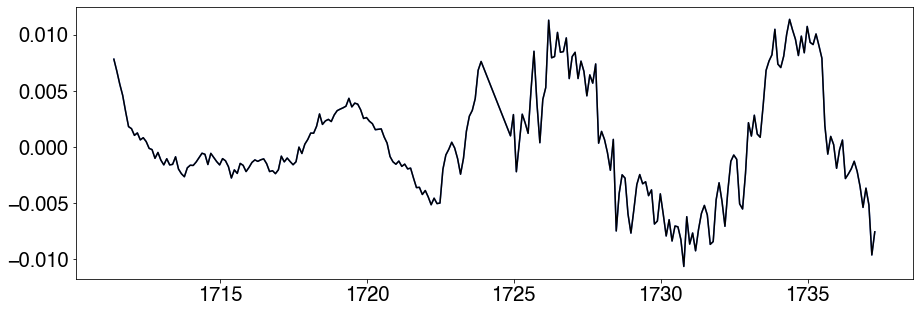

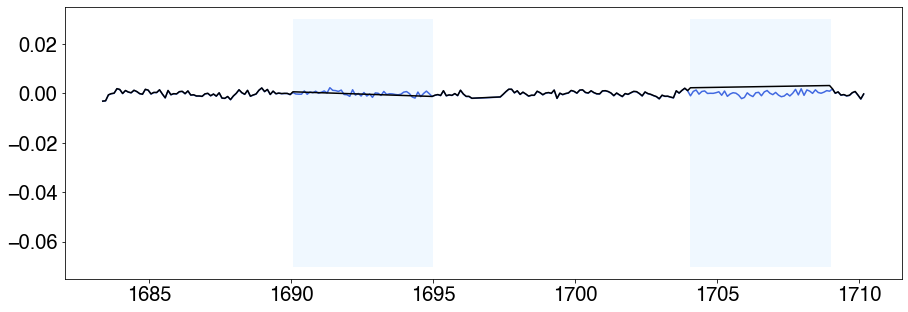

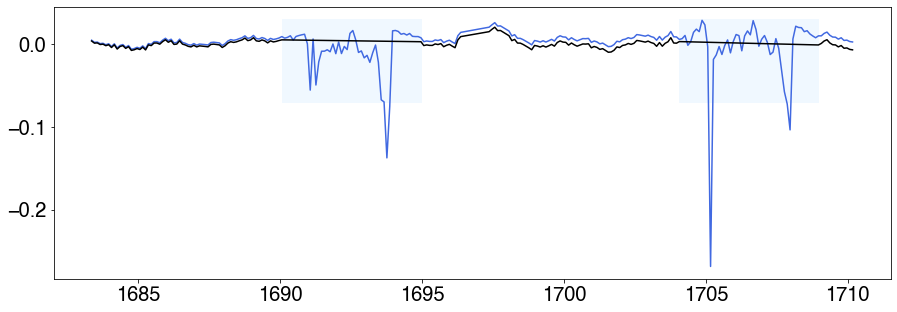

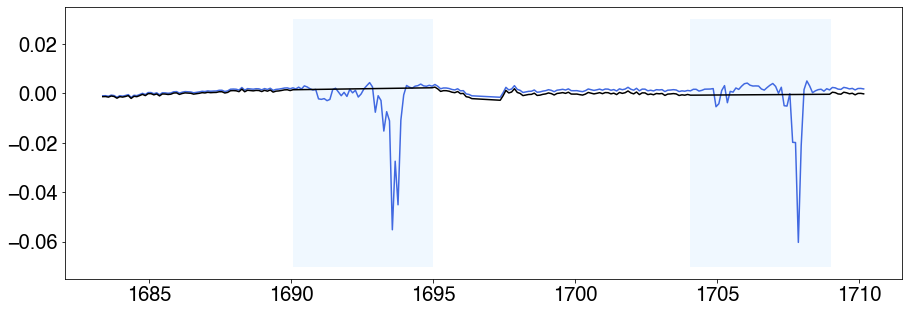

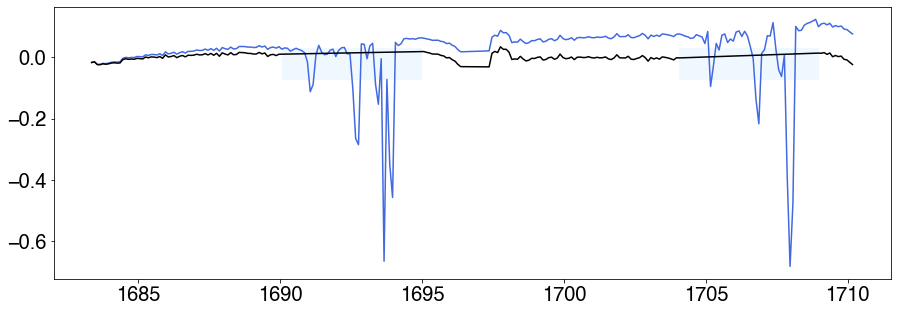

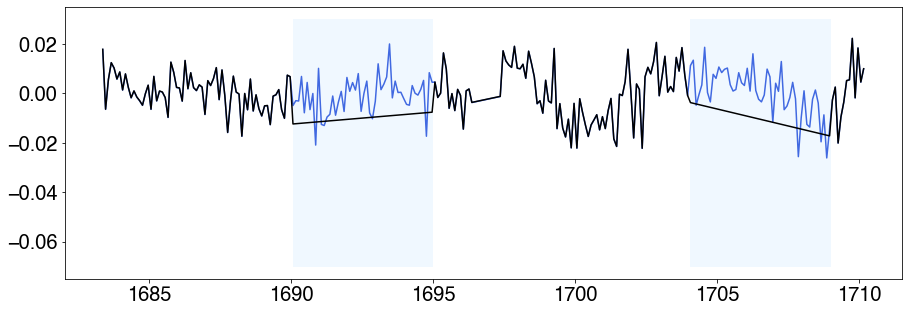

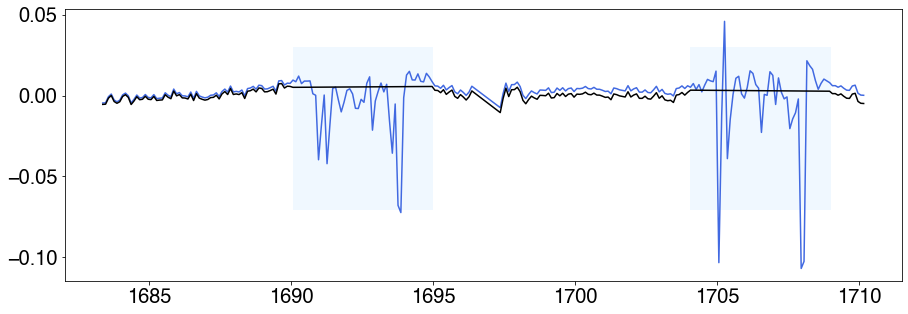

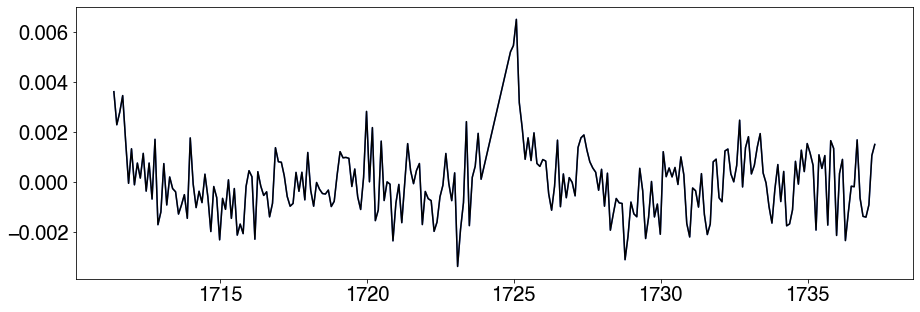

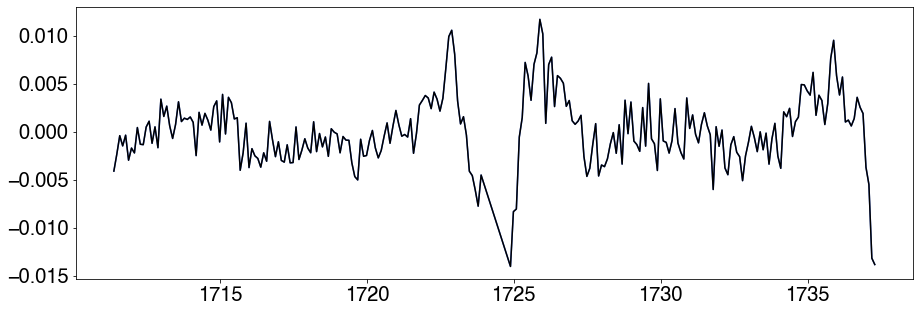

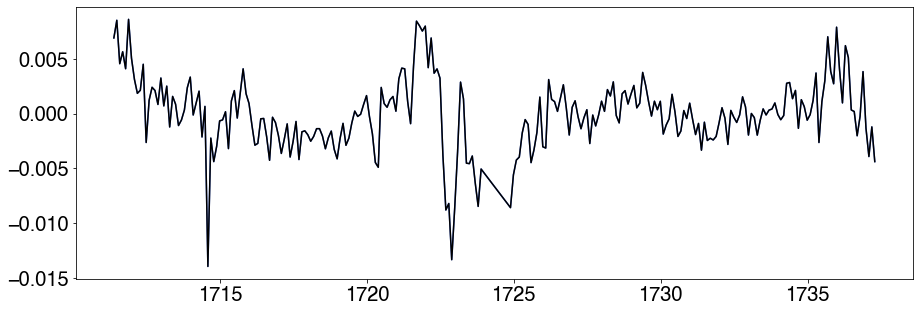

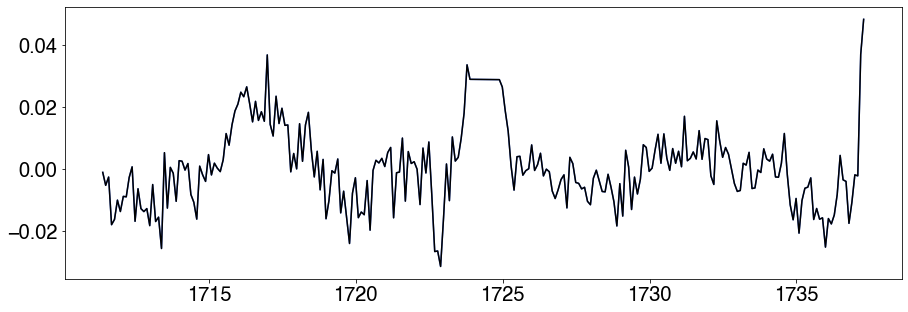

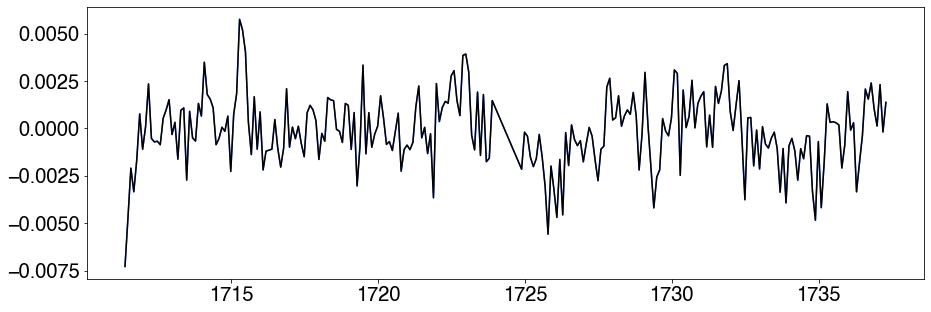

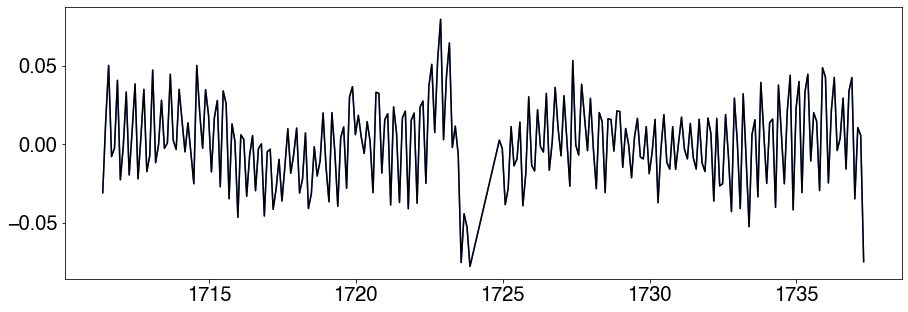

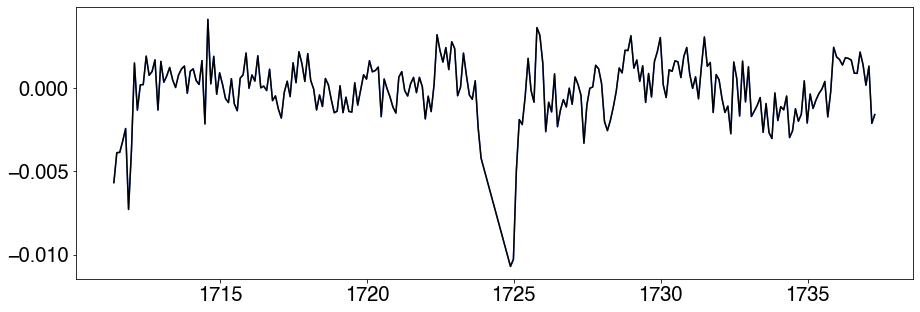

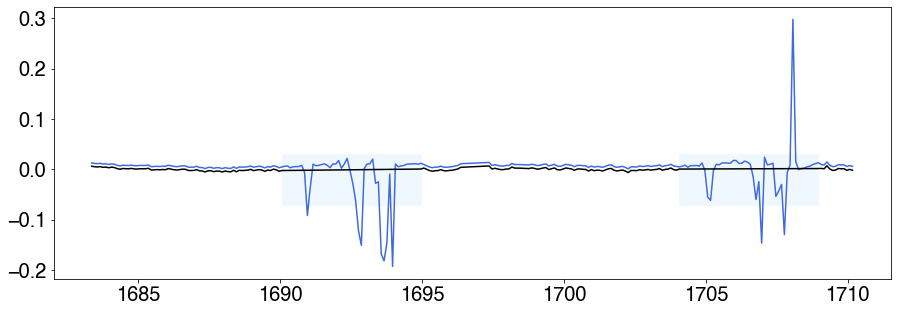

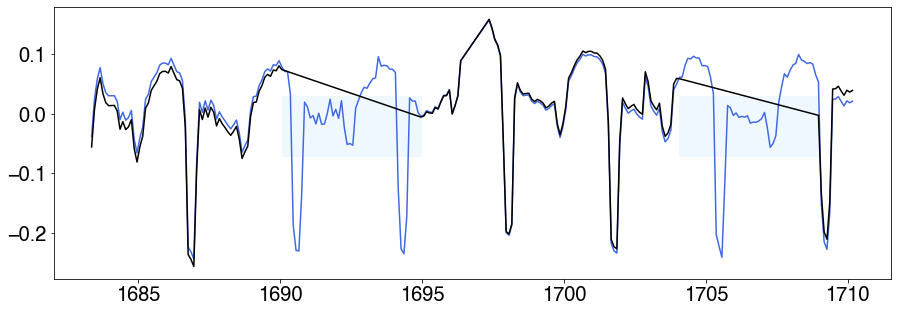

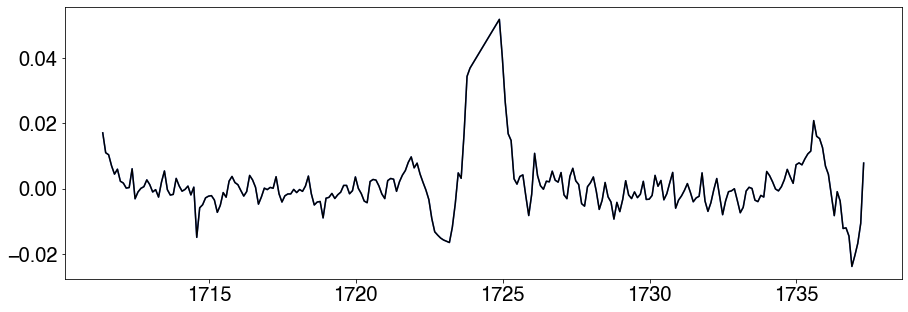

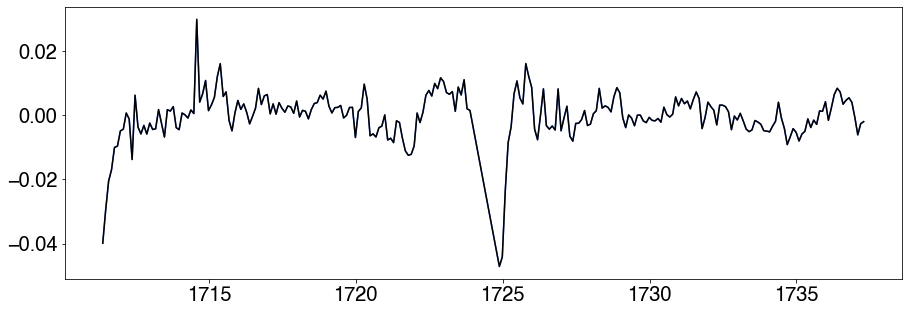

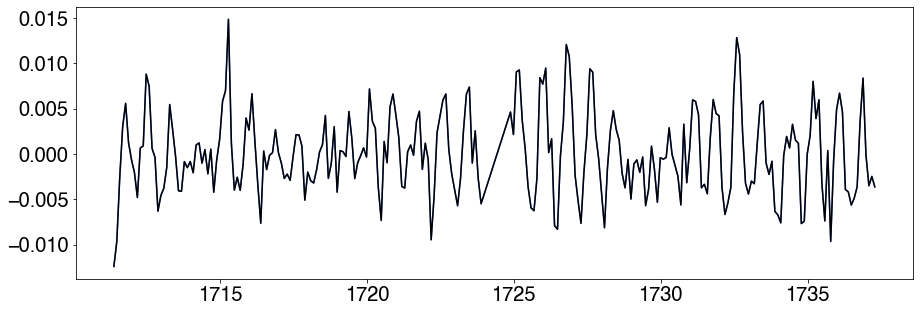

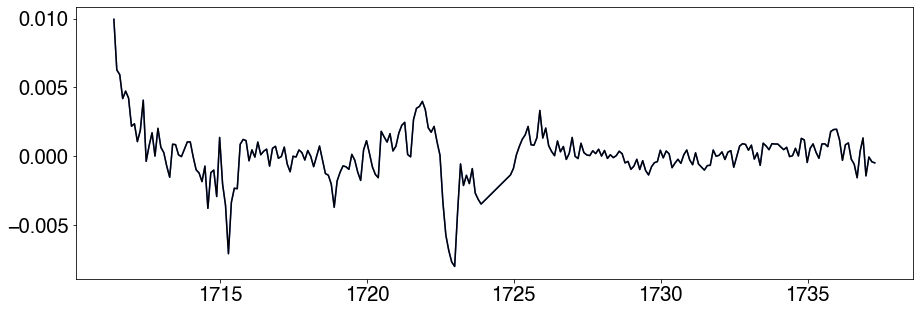

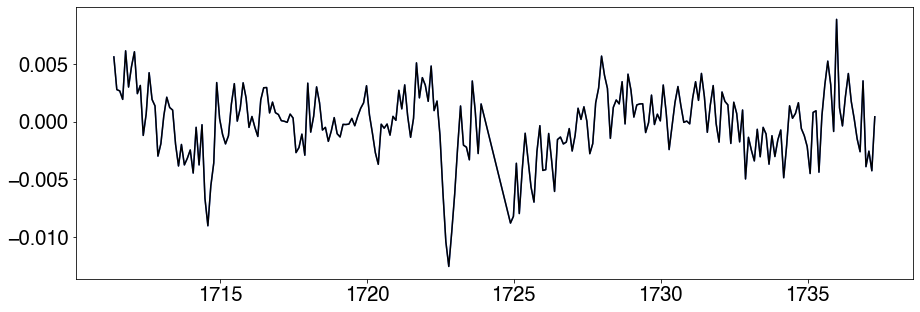

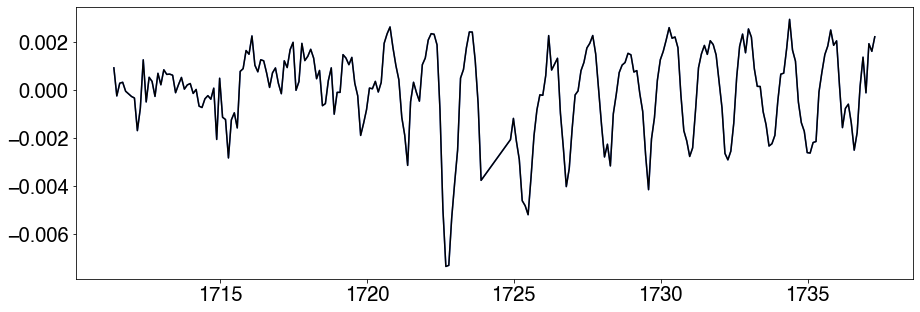

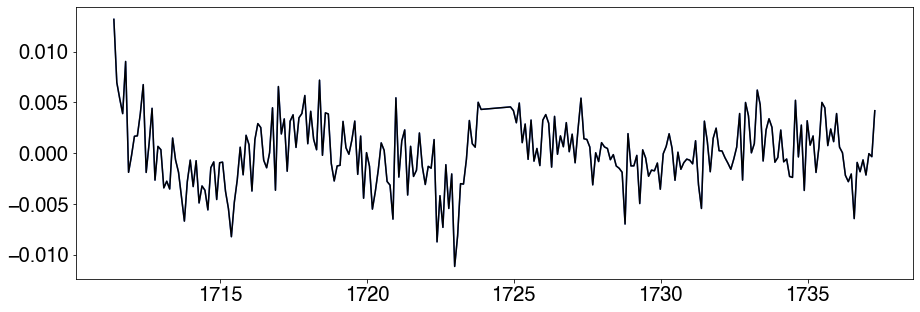

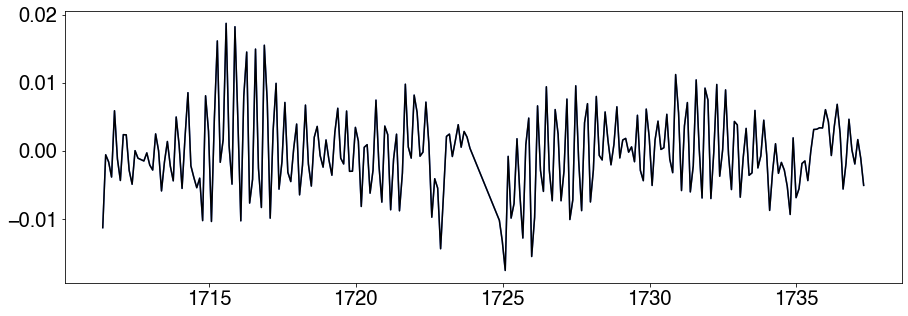

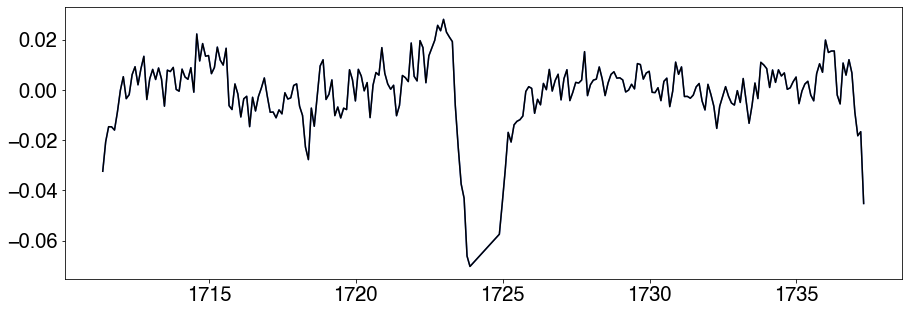

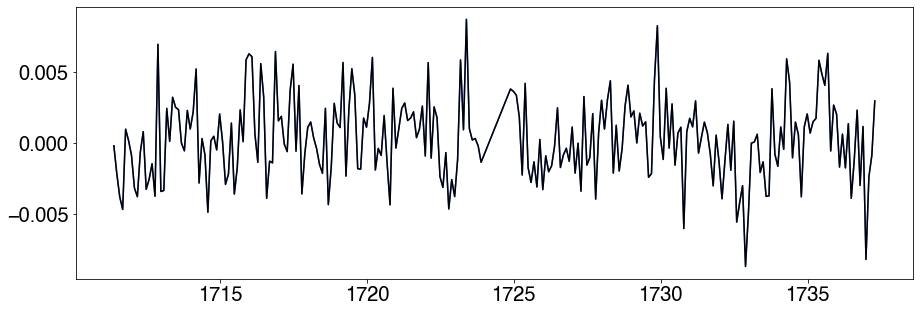

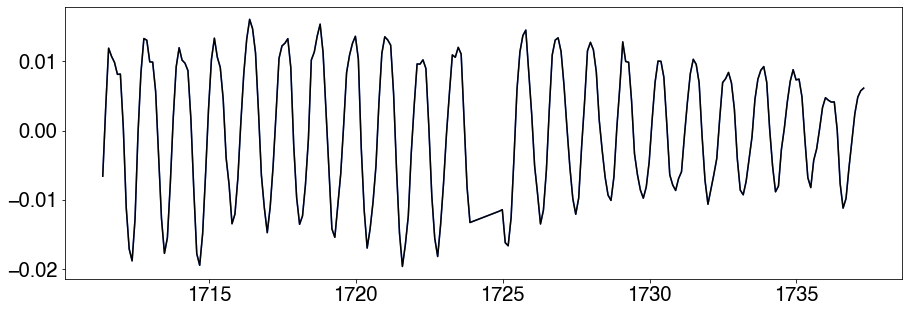

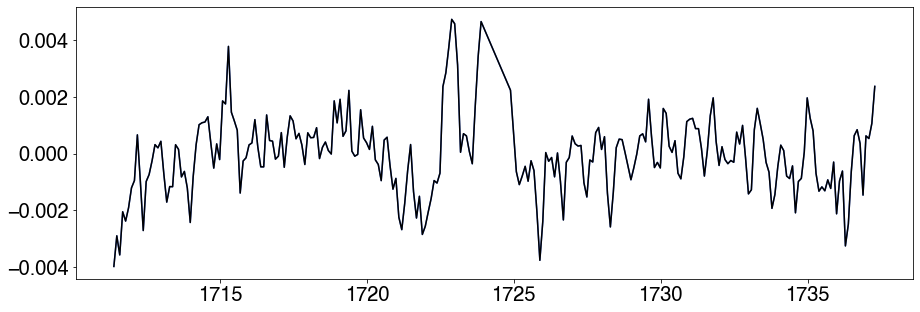

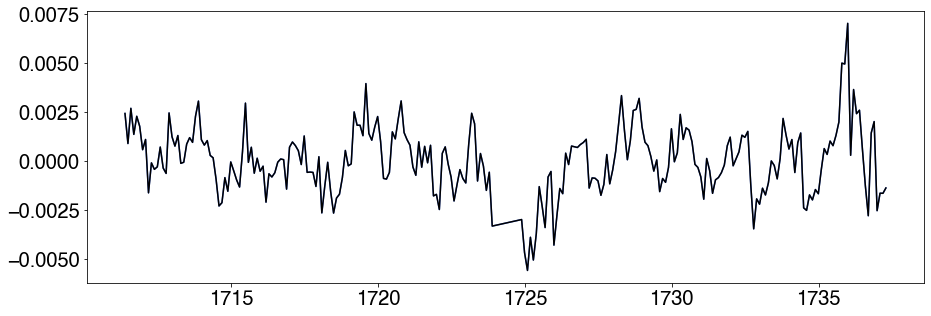

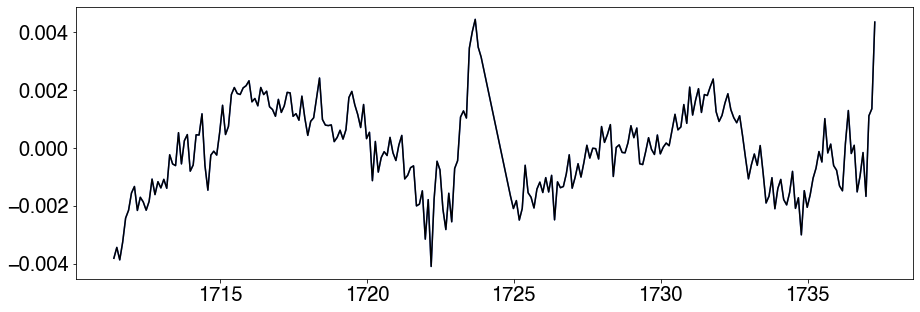

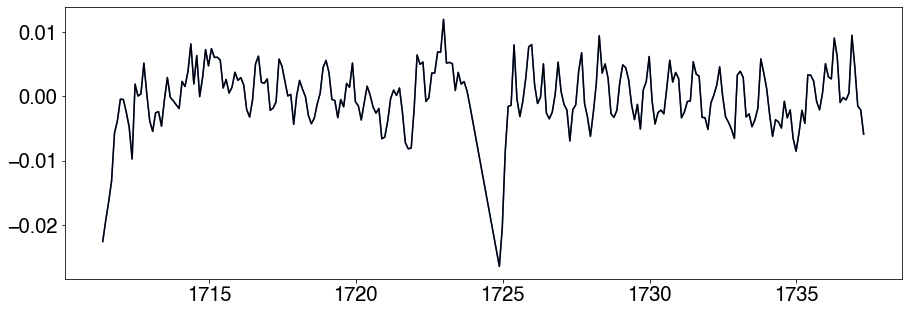

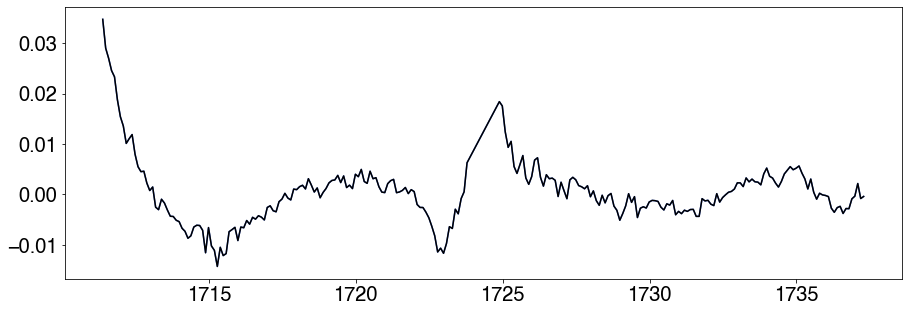

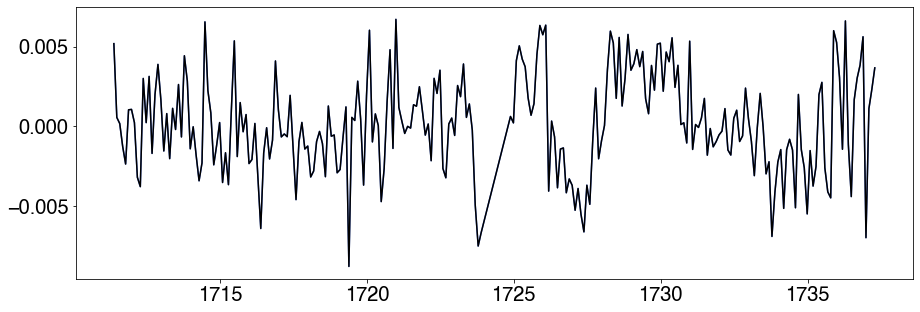

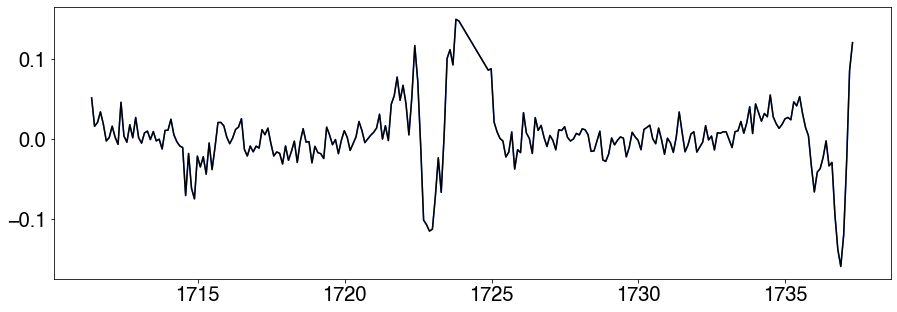

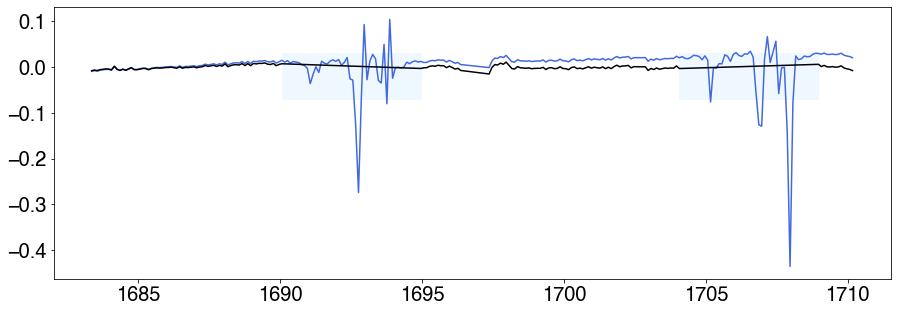

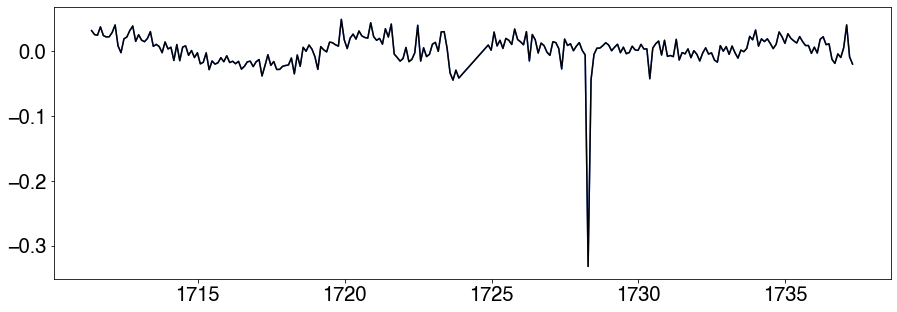

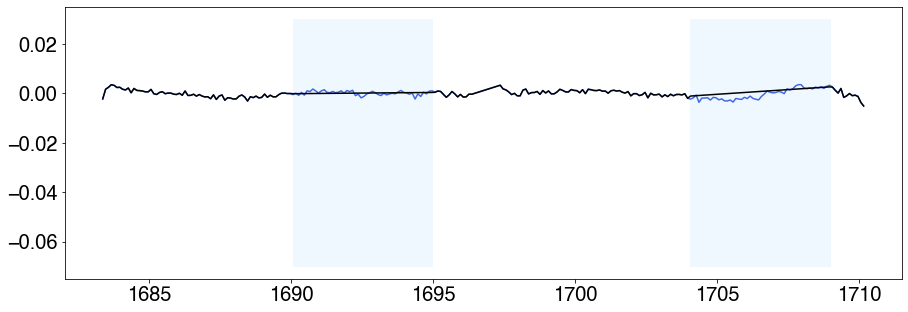

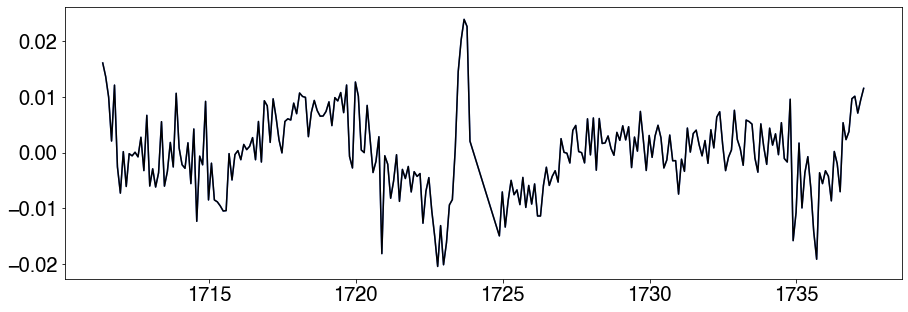

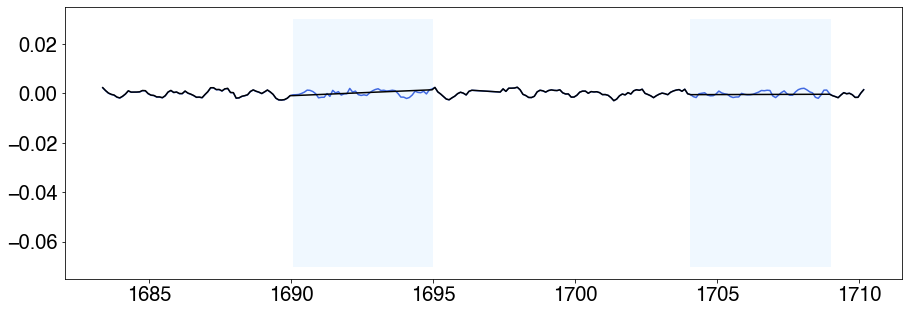

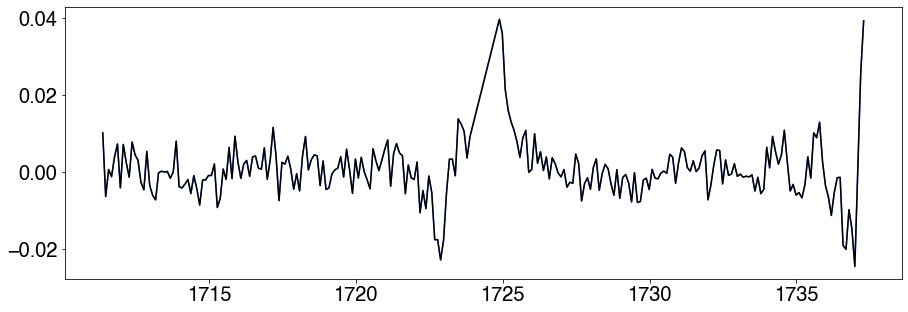

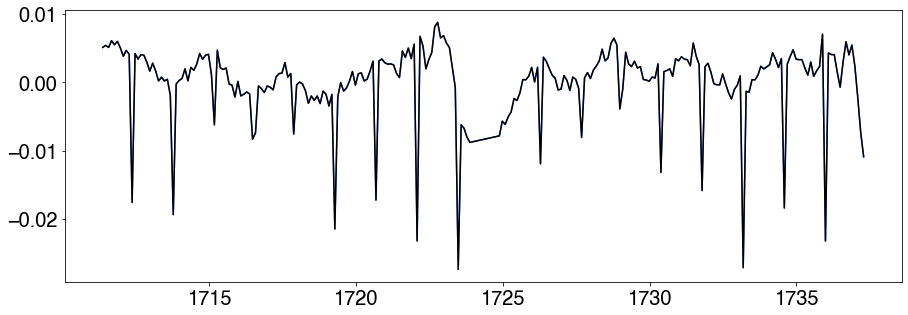

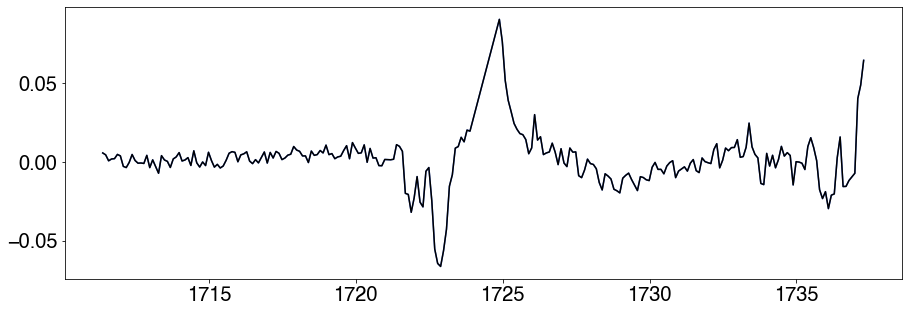

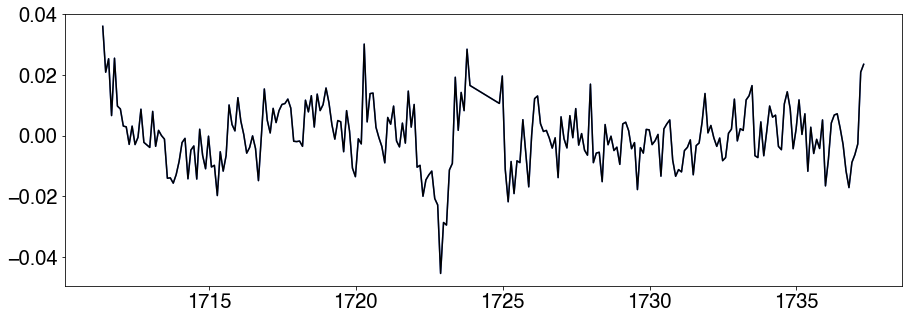

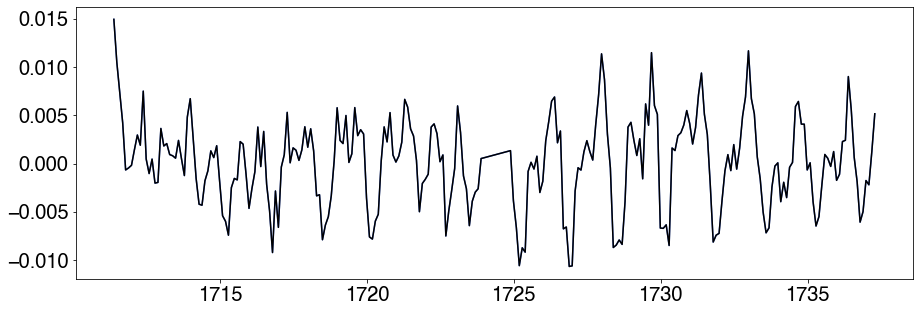

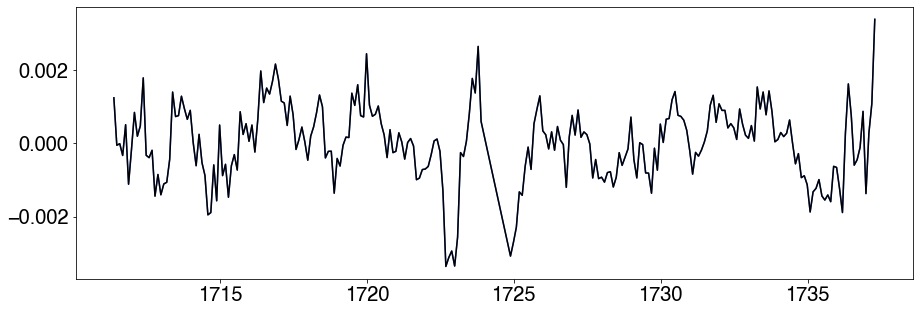

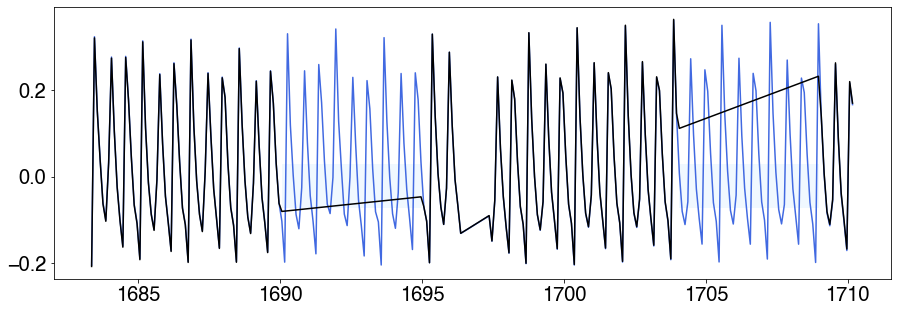

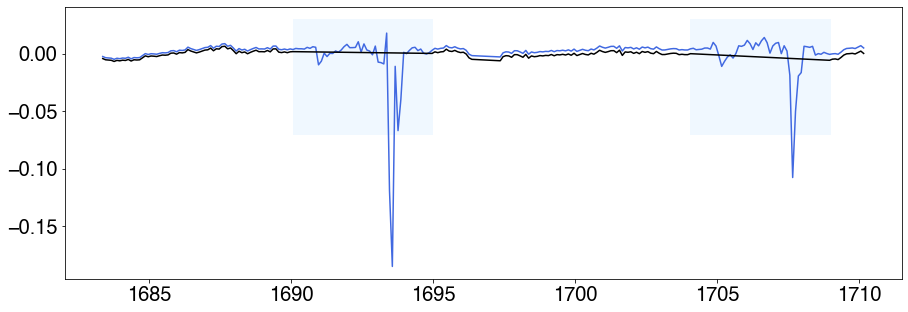

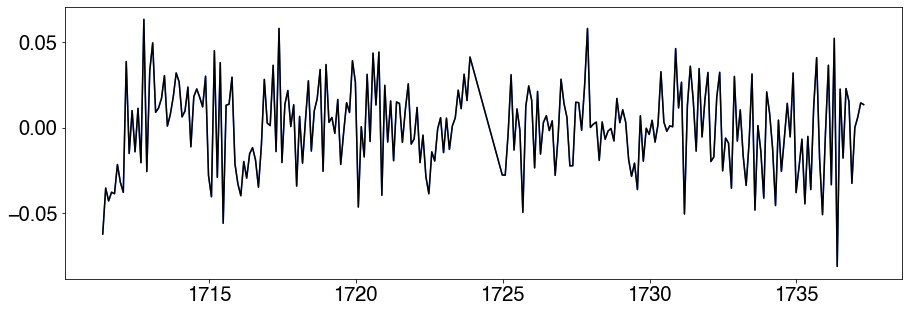

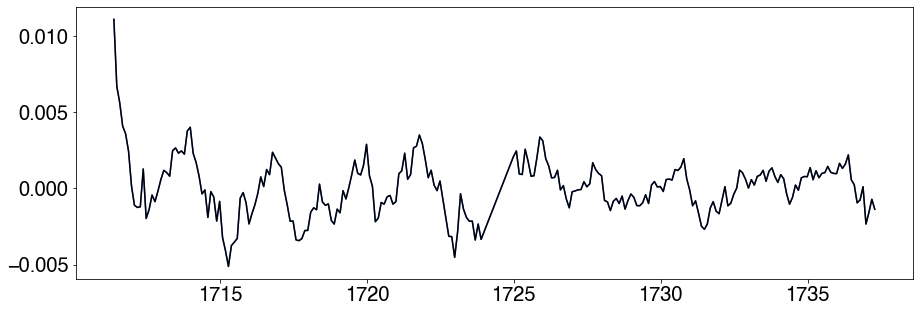

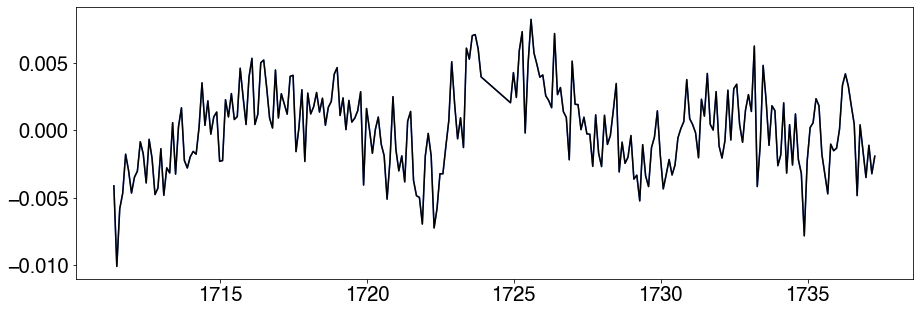

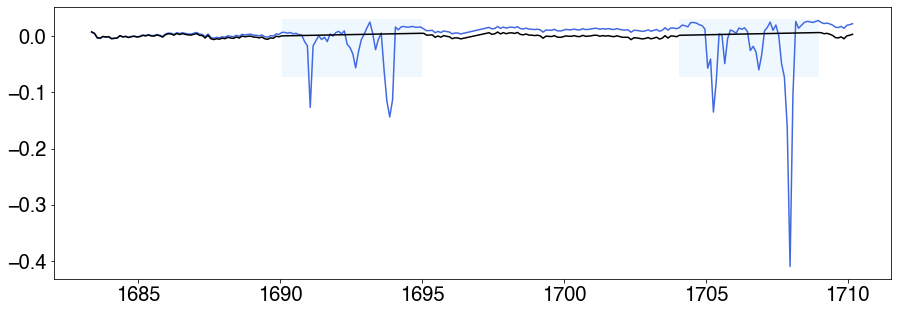

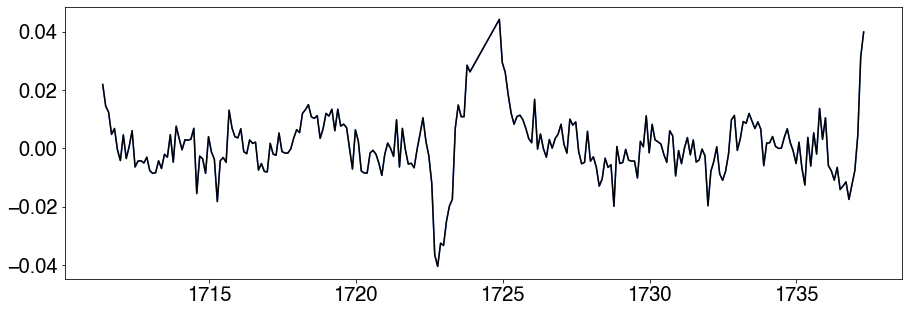

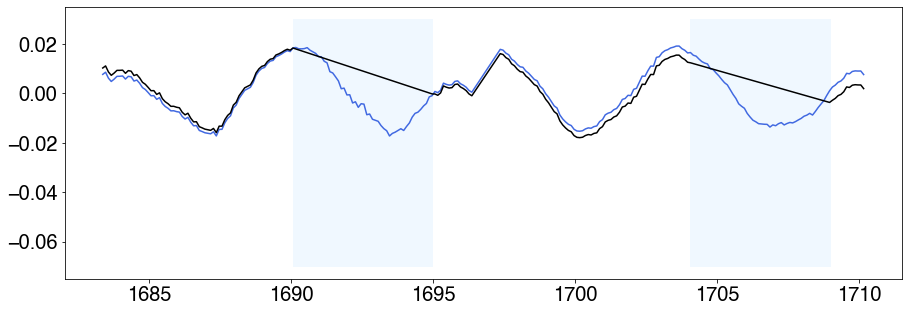

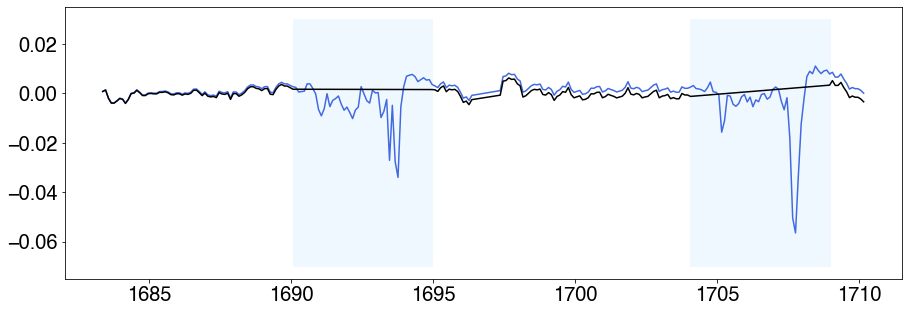

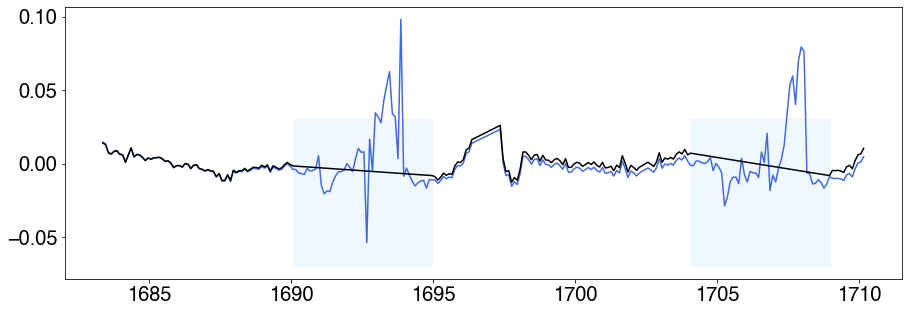

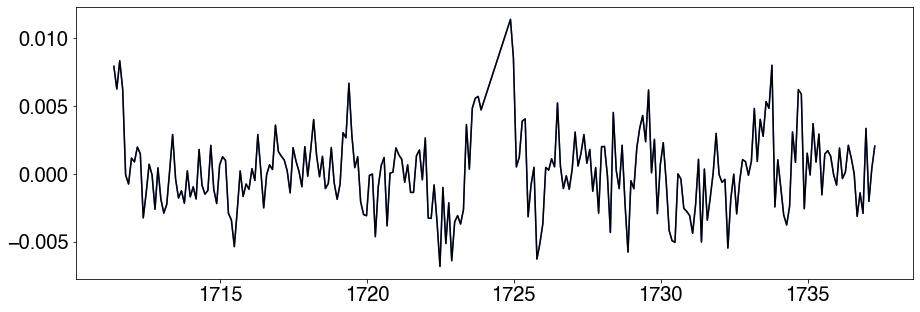

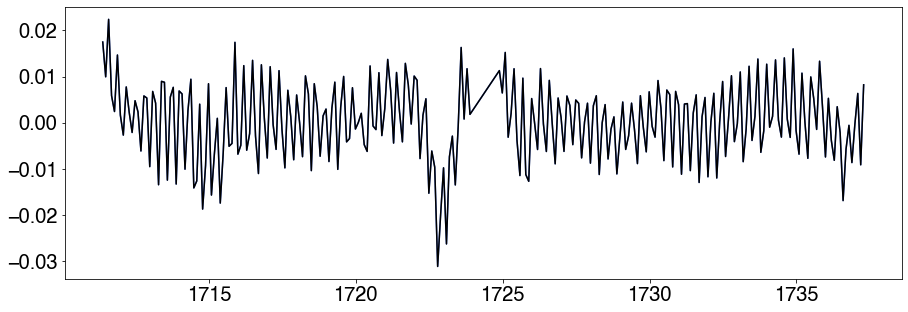

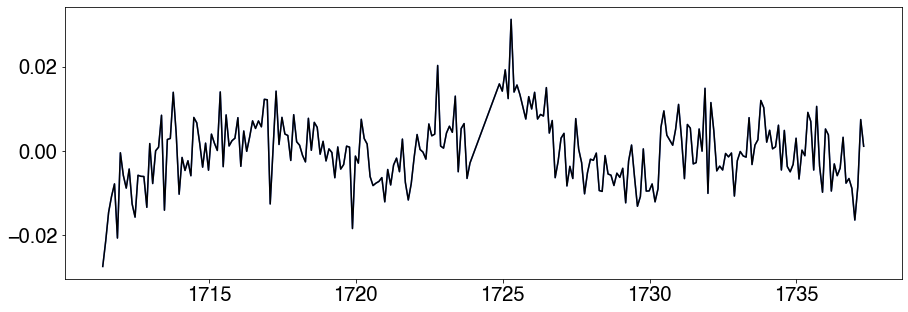

In [15]:
ls_periods_rem_flux = []
pdm_periods_rem_flux = []
exo_periods_rem_flux = []

for each, tic in enumerate(tics_short_periods[0:61]): 
    star = eleanor.Source(tic=tic)
    data = eleanor.TargetData(star, do_psf=True, do_pca=True)
    index = np.where(np.array(tics_short_periods) == tic)
    mcq_period = short_periods[index[0][0]]
    
    q = data.quality == 0
    time = data.time[q] 
    flux_nan = (data.pca_flux[q])[~np.isnan(data.pca_flux[q])]
    norm_flux = flux_nan/np.nanmedian(data.pca_flux[q])
   
    try: 
    #original 
        norm_flux_err = np.sqrt(norm_flux)
        resid = residuals(time, norm_flux, norm_flux_err)
        resid = resid[~np.isnan(resid)]
        time = time[~np.isnan(resid)]   
        
        f = interpolate.interp1d(time, resid)
        xnew = np.arange(time[0], time[-1], 0.1)
        flux = f(xnew) 
        flux_err = np.sqrt(flux)

        #cropping out section
        mask = (time <= 1695) & (time >= 1690)
        norm_flux_2 = norm_flux[~mask]
        time_masked = time[~mask]
    
        mask_2 = (time_masked <= 1709) & (time_masked >= 1704)
        norm_flux_mask = norm_flux_2[~mask_2]
        time_mask = time_masked[~mask_2]

        #removing trends 
        norm_flux_err_mask = np.sqrt(norm_flux_mask)
        resid_mask = residuals(time_mask, norm_flux_mask, norm_flux_err_mask)
        resid_mask = resid_mask[~np.isnan(resid_mask)]
        time_mask = time_mask[~np.isnan(resid_mask)]   
        
        #linear interpolation
        f = interpolate.interp1d(time_mask, resid_mask)
        xnew_mask = np.arange(time_mask[0], time_mask[-1], 0.1)
        flux_mask = f(xnew_mask) 
        flux_err_mask = np.sqrt(flux_mask)
    
        fig, axs = plt.subplots()
        fig.tight_layout(h_pad=6)
        plt.figure(figsize=(15,5))
        plt.plot(xnew, flux, 'royalblue')
        plt.fill_between(xnew, -0.07, 0.03,
                 where = (xnew > 1690) & (xnew <= 1695), 
                 color = 'aliceblue') 
        plt.fill_between(xnew, -0.07, 0.03,
                 where = (xnew > 1704) & (xnew <= 1709), 
                 color = 'aliceblue')

        plt.plot(xnew_mask, flux_mask, 'k')
        fig.savefig('tess_{0}_rem_flux.jpg'.format(each))
        plt.close(fig)

        #exo acf
        ex_1 = exoplanet.autocorr_estimator(xnew_mask, flux_mask, yerr= flux_err_mask, min_period = 0.1, max_period = 15)
        exo_period = ex_1['peaks'][0]['period']
        exo_periods_rem_flux.append(exo_period)

        
        #lomb-scargle 
        rotate_el = ss.RotationModel(xnew_mask, flux_mask, flux_err_mask)
        ls_period = rotate_el.ls_rotation()
        ls_periods_rem_flux.append(ls_period)
       
        #pdm 
        period_grid = np.linspace(.1, 10, 1000)
        pdm_period, period_err = rotate_el.pdm_rotation(period_grid, pdm_nbins=10)    
        pdm_periods_rem_flux.append(pdm_period)
        print('works!')
    
        
    except : 
        print('error')
        ls_periods_rem_flux.append(0)
        pdm_periods_rem_flux.append(0)
        exo_periods_rem_flux.append(0)

# 15, 35, 53 - the rebels

No eleanor postcard has been made for your target (yet). Using TessCut instead.




  0%|          | 0/1241 [00:00<?, ?it/s]

  0%|          | 1/1241 [00:11<3:50:56, 11.17s/it]

  0%|          | 4/1241 [00:11<2:41:30,  7.83s/it]

  0%|          | 6/1241 [00:11<1:53:13,  5.50s/it]

  1%|          | 9/1241 [00:11<1:19:17,  3.86s/it]

  1%|          | 13/1241 [00:11<55:30,  2.71s/it] 

  1%|▏         | 17/1241 [00:11<38:55,  1.91s/it]

  2%|▏         | 20/1241 [00:11<27:24,  1.35s/it]

  2%|▏         | 23/1241 [00:11<19:22,  1.05it/s]

  2%|▏         | 26/1241 [00:12<13:44,  1.47it/s]

  2%|▏         | 30/1241 [00:12<09:46,  2.06it/s]

  3%|▎         | 33/1241 [00:12<07:02,  2.86it/s]

  3%|▎         | 37/1241 [00:12<05:05,  3.94it/s]

  3%|▎         | 40/1241 [00:12<03:46,  5.31it/s]

  3%|▎         | 43/1241 [00:12<02:51,  6.97it/s]

  4%|▍         | 47/1241 [00:12<02:09,  9.19it/s]

  4%|▍         | 51/1241 [00:12<01:42, 11.56it/s]

  4%|▍         | 54/1241 [00:13<01:24, 13.97it/s]

  5%|▍         | 57/1241 [00:13<01:13, 16.14it/s]

  5%|▍         | 60/1241 [00:13<0

 42%|████▏     | 518/1241 [00:29<00:57, 12.66it/s]

 42%|████▏     | 522/1241 [00:29<00:50, 14.32it/s]

 43%|████▎     | 528/1241 [00:30<00:38, 18.41it/s]

 43%|████▎     | 532/1241 [00:30<00:37, 19.10it/s]

 43%|████▎     | 537/1241 [00:30<00:33, 21.17it/s]

 44%|████▎     | 540/1241 [00:30<00:38, 18.06it/s]

 44%|████▍     | 543/1241 [00:30<00:42, 16.49it/s]

 44%|████▍     | 548/1241 [00:30<00:33, 20.63it/s]

 44%|████▍     | 551/1241 [00:31<00:39, 17.52it/s]

 45%|████▍     | 554/1241 [00:31<00:47, 14.49it/s]

 45%|████▍     | 556/1241 [00:31<00:47, 14.54it/s]

 45%|████▍     | 558/1241 [00:31<00:54, 12.60it/s]

 45%|████▌     | 560/1241 [00:31<00:55, 12.18it/s]

 45%|████▌     | 562/1241 [00:32<01:07, 10.00it/s]

 45%|████▌     | 564/1241 [00:32<01:19,  8.55it/s]

 46%|████▌     | 566/1241 [00:32<01:25,  7.86it/s]

 46%|████▌     | 567/1241 [00:33<01:35,  7.08it/s]

 46%|████▌     | 568/1241 [00:33<01:42,  6.57it/s]

 46%|████▌     | 569/1241 [00:33<01:46,  6.32it/s]

 46%|████▌  

 56%|█████▌    | 692/1241 [00:55<01:40,  5.48it/s]

 56%|█████▌    | 693/1241 [00:56<01:39,  5.48it/s]

 56%|█████▌    | 694/1241 [00:56<01:38,  5.57it/s]

 56%|█████▌    | 695/1241 [00:56<01:36,  5.65it/s]

 56%|█████▌    | 696/1241 [00:56<01:39,  5.46it/s]

 56%|█████▌    | 697/1241 [00:56<01:38,  5.51it/s]

 56%|█████▌    | 698/1241 [00:57<01:37,  5.56it/s]

 56%|█████▋    | 699/1241 [00:57<01:35,  5.66it/s]

 56%|█████▋    | 700/1241 [00:57<01:34,  5.70it/s]

 56%|█████▋    | 701/1241 [00:57<01:34,  5.70it/s]

 57%|█████▋    | 702/1241 [00:57<01:35,  5.62it/s]

 57%|█████▋    | 703/1241 [00:57<01:37,  5.52it/s]

 57%|█████▋    | 704/1241 [00:58<01:35,  5.62it/s]

 57%|█████▋    | 705/1241 [00:58<01:35,  5.59it/s]

 57%|█████▋    | 706/1241 [00:58<01:35,  5.62it/s]

 57%|█████▋    | 707/1241 [00:58<01:35,  5.61it/s]

 57%|█████▋    | 708/1241 [00:58<01:34,  5.64it/s]

 57%|█████▋    | 709/1241 [00:58<01:36,  5.50it/s]

 57%|█████▋    | 710/1241 [00:59<01:35,  5.56it/s]

 57%|█████▋ 

 67%|██████▋   | 833/1241 [01:21<01:08,  5.95it/s]

 67%|██████▋   | 834/1241 [01:21<01:09,  5.88it/s]

 67%|██████▋   | 835/1241 [01:21<01:08,  5.94it/s]

 67%|██████▋   | 836/1241 [01:21<01:07,  6.03it/s]

 67%|██████▋   | 837/1241 [01:22<01:06,  6.09it/s]

 68%|██████▊   | 838/1241 [01:22<01:05,  6.14it/s]

 68%|██████▊   | 839/1241 [01:22<01:05,  6.14it/s]

 68%|██████▊   | 840/1241 [01:22<01:05,  6.08it/s]

 68%|██████▊   | 841/1241 [01:22<01:05,  6.10it/s]

 68%|██████▊   | 842/1241 [01:22<01:04,  6.16it/s]

 68%|██████▊   | 843/1241 [01:23<01:04,  6.20it/s]

 68%|██████▊   | 844/1241 [01:23<01:03,  6.27it/s]

 68%|██████▊   | 845/1241 [01:23<01:03,  6.25it/s]

 68%|██████▊   | 846/1241 [01:23<01:03,  6.24it/s]

 68%|██████▊   | 847/1241 [01:23<01:05,  6.03it/s]

 68%|██████▊   | 848/1241 [01:23<01:05,  6.03it/s]

 68%|██████▊   | 849/1241 [01:24<01:04,  6.08it/s]

 68%|██████▊   | 850/1241 [01:24<01:04,  6.10it/s]

 69%|██████▊   | 851/1241 [01:24<01:03,  6.16it/s]

 69%|██████▊

 78%|███████▊  | 974/1241 [01:56<01:10,  3.81it/s]

 79%|███████▊  | 975/1241 [01:56<01:02,  4.23it/s]

 79%|███████▊  | 976/1241 [01:56<01:00,  4.37it/s]

 79%|███████▊  | 977/1241 [01:57<00:57,  4.55it/s]

 79%|███████▉  | 978/1241 [01:57<00:53,  4.92it/s]

 79%|███████▉  | 979/1241 [01:57<00:50,  5.18it/s]

 79%|███████▉  | 980/1241 [01:57<00:47,  5.47it/s]

 79%|███████▉  | 981/1241 [01:57<00:46,  5.63it/s]

 79%|███████▉  | 982/1241 [01:57<00:45,  5.74it/s]

 79%|███████▉  | 983/1241 [01:58<00:43,  5.86it/s]

 79%|███████▉  | 984/1241 [01:58<00:43,  5.88it/s]

 79%|███████▉  | 985/1241 [01:58<00:42,  5.98it/s]

 79%|███████▉  | 986/1241 [01:58<00:42,  6.03it/s]

 80%|███████▉  | 987/1241 [01:58<00:42,  6.05it/s]

 80%|███████▉  | 988/1241 [01:58<00:41,  6.08it/s]

 80%|███████▉  | 989/1241 [01:59<00:41,  6.06it/s]

 80%|███████▉  | 990/1241 [01:59<00:41,  6.09it/s]

 80%|███████▉  | 991/1241 [01:59<00:40,  6.10it/s]

 80%|███████▉  | 992/1241 [01:59<00:40,  6.09it/s]

 80%|███████

 90%|████████▉ | 1113/1241 [02:19<00:23,  5.46it/s]

 90%|████████▉ | 1114/1241 [02:19<00:22,  5.65it/s]

 90%|████████▉ | 1115/1241 [02:20<00:22,  5.69it/s]

 90%|████████▉ | 1116/1241 [02:20<00:21,  5.89it/s]

 90%|█████████ | 1117/1241 [02:20<00:20,  5.98it/s]

 90%|█████████ | 1118/1241 [02:20<00:20,  6.04it/s]

 90%|█████████ | 1119/1241 [02:20<00:20,  6.08it/s]

 90%|█████████ | 1120/1241 [02:20<00:19,  6.13it/s]

 90%|█████████ | 1121/1241 [02:21<00:19,  6.14it/s]

 90%|█████████ | 1122/1241 [02:21<00:19,  6.16it/s]

 90%|█████████ | 1123/1241 [02:21<00:19,  6.16it/s]

 91%|█████████ | 1124/1241 [02:21<00:18,  6.21it/s]

 91%|█████████ | 1125/1241 [02:21<00:19,  6.07it/s]

 91%|█████████ | 1126/1241 [02:21<00:18,  6.08it/s]

 91%|█████████ | 1127/1241 [02:22<00:18,  6.16it/s]

 91%|█████████ | 1128/1241 [02:22<00:18,  6.14it/s]

 91%|█████████ | 1129/1241 [02:22<00:18,  6.15it/s]

 91%|█████████ | 1130/1241 [02:22<00:17,  6.19it/s]

 91%|█████████ | 1131/1241 [02:22<00:17,  6.15

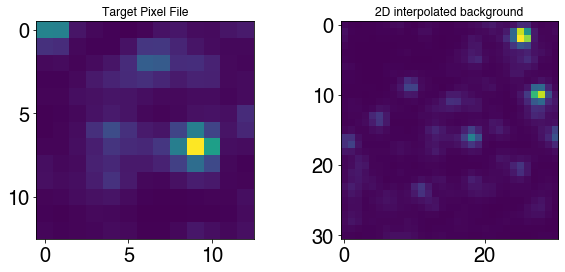

In [65]:
star15 = eleanor.Source(tic=tics_short_periods[15])
data15 = eleanor.TargetData(star15, do_psf=True, do_pca=True)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,4))
ax1.imshow(data15.tpf[0])
ax1.set_title('Target Pixel File')
ax2.imshow(data15.bkg_tpf[0])
ax2.set_title('2D interpolated background');

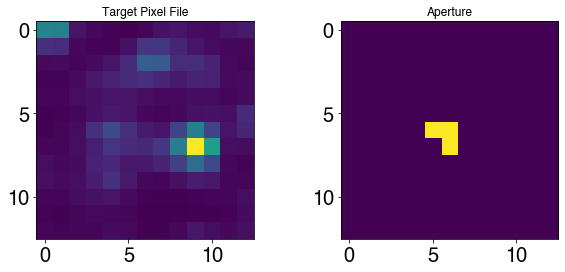

In [66]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,4))
ax1.imshow(data15.tpf[0])
ax1.set_title('Target Pixel File')
ax2.imshow(data15.aperture)
ax2.set_title('Aperture');

In [67]:
star15 = search_targetpixelfile('TIC 120890400').download(quality_bitmask='default');

In [38]:
star15.interact_sky()

In [39]:
star15.interact()

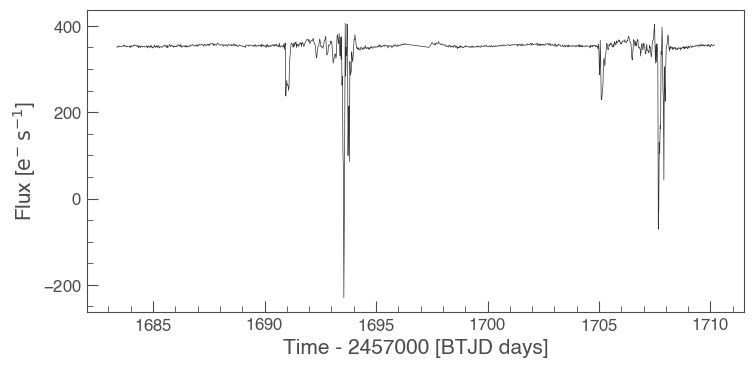

In [68]:
lk = data15.to_lightkurve()
lk.plot()

In [69]:
star35 = eleanor.Source(tic=tics_short_periods[35])
data35 = eleanor.TargetData(star35, do_psf=True, do_pca=True)

No eleanor postcard has been made for your target (yet). Using TessCut instead.




  0%|          | 0/1197 [00:00<?, ?it/s]

  0%|          | 1/1197 [00:10<3:35:16, 10.80s/it]

  0%|          | 2/1197 [00:10<2:31:37,  7.61s/it]

  0%|          | 3/1197 [00:11<1:47:03,  5.38s/it]

  0%|          | 4/1197 [00:11<1:15:51,  3.82s/it]

  0%|          | 5/1197 [00:11<54:10,  2.73s/it]  

  1%|          | 6/1197 [00:11<39:22,  1.98s/it]

  1%|          | 7/1197 [00:11<28:44,  1.45s/it]

  1%|          | 8/1197 [00:12<21:15,  1.07s/it]

  1%|          | 9/1197 [00:12<16:00,  1.24it/s]

  1%|          | 10/1197 [00:12<12:15,  1.61it/s]

  1%|          | 11/1197 [00:12<09:45,  2.03it/s]

  1%|          | 13/1197 [00:12<07:25,  2.66it/s]

  1%|          | 14/1197 [00:13<06:15,  3.15it/s]

  1%|▏         | 15/1197 [00:13<05:27,  3.61it/s]

  1%|▏         | 17/1197 [00:13<04:10,  4.71it/s]

  2%|▏         | 18/1197 [00:13<04:09,  4.73it/s]

  2%|▏         | 20/1197 [00:13<03:18,  5.94it/s]

  2%|▏         | 21/1197 [00:13<03:30,  5.58it/s]

  2%|▏         | 23/1197 [00:14<03:03

 13%|█▎        | 150/1197 [00:33<02:22,  7.36it/s]

 13%|█▎        | 151/1197 [00:33<02:22,  7.36it/s]

 13%|█▎        | 152/1197 [00:33<02:22,  7.34it/s]

 13%|█▎        | 153/1197 [00:34<02:37,  6.62it/s]

 13%|█▎        | 154/1197 [00:34<02:28,  7.03it/s]

 13%|█▎        | 155/1197 [00:34<02:20,  7.41it/s]

 13%|█▎        | 156/1197 [00:34<02:17,  7.58it/s]

 13%|█▎        | 157/1197 [00:34<02:14,  7.75it/s]

 13%|█▎        | 158/1197 [00:34<02:11,  7.90it/s]

 13%|█▎        | 159/1197 [00:34<02:09,  8.00it/s]

 13%|█▎        | 160/1197 [00:35<02:10,  7.93it/s]

 13%|█▎        | 161/1197 [00:35<02:09,  7.98it/s]

 14%|█▎        | 162/1197 [00:35<02:08,  8.05it/s]

 14%|█▎        | 163/1197 [00:35<02:07,  8.09it/s]

 14%|█▎        | 164/1197 [00:35<02:08,  8.07it/s]

 14%|█▍        | 165/1197 [00:35<02:08,  8.06it/s]

 14%|█▍        | 166/1197 [00:35<02:07,  8.06it/s]

 14%|█▍        | 167/1197 [00:35<02:07,  8.08it/s]

 14%|█▍        | 168/1197 [00:36<02:09,  7.94it/s]

 14%|█▍     

 24%|██▍       | 293/1197 [00:53<02:02,  7.36it/s]

 25%|██▍       | 294/1197 [00:53<02:01,  7.44it/s]

 25%|██▍       | 295/1197 [00:53<02:00,  7.49it/s]

 25%|██▍       | 296/1197 [00:53<02:01,  7.44it/s]

 25%|██▍       | 297/1197 [00:53<02:01,  7.43it/s]

 25%|██▍       | 298/1197 [00:53<02:17,  6.54it/s]

 25%|██▍       | 299/1197 [00:53<02:14,  6.69it/s]

 25%|██▌       | 300/1197 [00:54<02:07,  7.02it/s]

 25%|██▌       | 301/1197 [00:54<02:03,  7.27it/s]

 25%|██▌       | 302/1197 [00:54<02:00,  7.42it/s]

 25%|██▌       | 303/1197 [00:54<01:58,  7.52it/s]

 25%|██▌       | 304/1197 [00:54<01:58,  7.54it/s]

 25%|██▌       | 305/1197 [00:54<01:58,  7.55it/s]

 26%|██▌       | 306/1197 [00:54<01:56,  7.64it/s]

 26%|██▌       | 307/1197 [00:55<01:56,  7.62it/s]

 26%|██▌       | 308/1197 [00:55<01:56,  7.64it/s]

 26%|██▌       | 309/1197 [00:55<01:55,  7.66it/s]

 26%|██▌       | 310/1197 [00:55<01:54,  7.73it/s]

 26%|██▌       | 311/1197 [00:55<01:53,  7.79it/s]

 26%|██▌    

 36%|███▋      | 434/1197 [01:11<01:39,  7.69it/s]

 36%|███▋      | 435/1197 [01:11<01:41,  7.53it/s]

 36%|███▋      | 436/1197 [01:11<01:40,  7.60it/s]

 37%|███▋      | 437/1197 [01:12<01:38,  7.75it/s]

 37%|███▋      | 438/1197 [01:12<01:36,  7.90it/s]

 37%|███▋      | 439/1197 [01:12<01:35,  7.96it/s]

 37%|███▋      | 440/1197 [01:12<01:33,  8.11it/s]

 37%|███▋      | 441/1197 [01:12<01:33,  8.04it/s]

 37%|███▋      | 442/1197 [01:12<01:34,  7.99it/s]

 37%|███▋      | 443/1197 [01:12<01:34,  7.94it/s]

 37%|███▋      | 444/1197 [01:12<01:34,  7.97it/s]

 37%|███▋      | 445/1197 [01:13<01:35,  7.91it/s]

 37%|███▋      | 446/1197 [01:13<01:35,  7.88it/s]

 37%|███▋      | 447/1197 [01:13<01:34,  7.95it/s]

 37%|███▋      | 448/1197 [01:13<01:34,  7.94it/s]

 38%|███▊      | 449/1197 [01:13<01:34,  7.94it/s]

 38%|███▊      | 450/1197 [01:13<01:34,  7.94it/s]

 38%|███▊      | 451/1197 [01:13<01:34,  7.93it/s]

 38%|███▊      | 452/1197 [01:13<01:34,  7.85it/s]

 38%|███▊   

 48%|████▊     | 575/1197 [01:33<01:48,  5.74it/s]

 48%|████▊     | 576/1197 [01:34<01:47,  5.78it/s]

 48%|████▊     | 577/1197 [01:34<01:45,  5.88it/s]

 48%|████▊     | 578/1197 [01:34<01:45,  5.89it/s]

 48%|████▊     | 579/1197 [01:34<01:43,  5.97it/s]

 48%|████▊     | 580/1197 [01:34<01:43,  5.97it/s]

 49%|████▊     | 581/1197 [01:34<01:43,  5.95it/s]

 49%|████▊     | 582/1197 [01:35<01:42,  5.99it/s]

 49%|████▊     | 583/1197 [01:35<01:42,  6.01it/s]

 49%|████▉     | 584/1197 [01:35<01:41,  6.02it/s]

 49%|████▉     | 585/1197 [01:35<01:41,  6.03it/s]

 49%|████▉     | 586/1197 [01:35<01:41,  6.02it/s]

 49%|████▉     | 587/1197 [01:35<01:41,  6.00it/s]

 49%|████▉     | 588/1197 [01:36<01:41,  5.99it/s]

 49%|████▉     | 589/1197 [01:36<01:41,  5.99it/s]

 49%|████▉     | 590/1197 [01:36<01:41,  6.01it/s]

 49%|████▉     | 591/1197 [01:36<01:33,  6.46it/s]

 49%|████▉     | 592/1197 [01:36<01:28,  6.84it/s]

 50%|████▉     | 593/1197 [01:36<01:24,  7.19it/s]

 50%|████▉  

 60%|█████▉    | 716/1197 [02:00<01:11,  6.77it/s]

 60%|█████▉    | 717/1197 [02:00<01:15,  6.39it/s]

 60%|█████▉    | 718/1197 [02:00<01:16,  6.26it/s]

 60%|██████    | 719/1197 [02:00<01:10,  6.73it/s]

 60%|██████    | 720/1197 [02:00<01:07,  7.03it/s]

 60%|██████    | 721/1197 [02:00<01:10,  6.73it/s]

 60%|██████    | 722/1197 [02:01<01:15,  6.33it/s]

 60%|██████    | 723/1197 [02:01<01:09,  6.78it/s]

 60%|██████    | 724/1197 [02:01<01:06,  7.11it/s]

 61%|██████    | 725/1197 [02:01<01:09,  6.75it/s]

 61%|██████    | 726/1197 [02:01<01:11,  6.57it/s]

 61%|██████    | 727/1197 [02:01<01:13,  6.41it/s]

 61%|██████    | 728/1197 [02:01<01:08,  6.84it/s]

 61%|██████    | 729/1197 [02:02<01:11,  6.54it/s]

 61%|██████    | 730/1197 [02:02<01:13,  6.35it/s]

 61%|██████    | 731/1197 [02:02<01:14,  6.26it/s]

 61%|██████    | 732/1197 [02:02<01:09,  6.71it/s]

 61%|██████    | 733/1197 [02:02<01:11,  6.51it/s]

 61%|██████▏   | 734/1197 [02:02<01:12,  6.40it/s]

 61%|██████▏

 72%|███████▏  | 858/1197 [02:21<00:57,  5.85it/s]

 72%|███████▏  | 859/1197 [02:21<00:57,  5.90it/s]

 72%|███████▏  | 860/1197 [02:21<00:56,  5.95it/s]

 72%|███████▏  | 861/1197 [02:21<00:56,  5.99it/s]

 72%|███████▏  | 862/1197 [02:21<00:51,  6.48it/s]

 72%|███████▏  | 863/1197 [02:21<00:52,  6.37it/s]

 72%|███████▏  | 864/1197 [02:22<00:53,  6.17it/s]

 72%|███████▏  | 865/1197 [02:22<00:54,  6.09it/s]

 72%|███████▏  | 866/1197 [02:22<00:54,  6.08it/s]

 72%|███████▏  | 867/1197 [02:22<00:54,  6.06it/s]

 73%|███████▎  | 868/1197 [02:22<00:54,  6.06it/s]

 73%|███████▎  | 869/1197 [02:22<00:53,  6.11it/s]

 73%|███████▎  | 870/1197 [02:23<00:54,  6.03it/s]

 73%|███████▎  | 871/1197 [02:23<00:53,  6.04it/s]

 73%|███████▎  | 872/1197 [02:23<00:53,  6.09it/s]

 73%|███████▎  | 873/1197 [02:23<00:53,  6.08it/s]

 73%|███████▎  | 874/1197 [02:23<00:53,  6.08it/s]

 73%|███████▎  | 875/1197 [02:23<00:52,  6.11it/s]

 73%|███████▎  | 876/1197 [02:24<00:52,  6.06it/s]

 73%|███████

 84%|████████▎ | 1002/1197 [02:43<00:32,  5.98it/s]

 84%|████████▍ | 1003/1197 [02:43<00:32,  5.88it/s]

 84%|████████▍ | 1004/1197 [02:43<00:32,  5.95it/s]

 84%|████████▍ | 1005/1197 [02:43<00:32,  5.98it/s]

 84%|████████▍ | 1006/1197 [02:43<00:31,  5.97it/s]

 84%|████████▍ | 1007/1197 [02:44<00:31,  6.02it/s]

 84%|████████▍ | 1008/1197 [02:44<00:31,  6.04it/s]

 84%|████████▍ | 1009/1197 [02:44<00:28,  6.54it/s]

 84%|████████▍ | 1010/1197 [02:44<00:29,  6.39it/s]

 84%|████████▍ | 1011/1197 [02:44<00:30,  6.03it/s]

 85%|████████▍ | 1012/1197 [02:44<00:28,  6.54it/s]

 85%|████████▍ | 1013/1197 [02:44<00:26,  6.87it/s]

 85%|████████▍ | 1014/1197 [02:45<00:25,  7.11it/s]

 85%|████████▍ | 1015/1197 [02:45<00:24,  7.32it/s]

 85%|████████▍ | 1016/1197 [02:45<00:24,  7.49it/s]

 85%|████████▍ | 1017/1197 [02:45<00:23,  7.66it/s]

 85%|████████▌ | 1018/1197 [02:45<00:25,  6.99it/s]

 85%|████████▌ | 1019/1197 [02:45<00:26,  6.61it/s]

 85%|████████▌ | 1020/1197 [02:45<00:25,  6.84

 95%|█████████▌| 1140/1197 [03:03<00:09,  5.88it/s]

 95%|█████████▌| 1141/1197 [03:03<00:09,  5.87it/s]

 95%|█████████▌| 1142/1197 [03:03<00:09,  5.92it/s]

 95%|█████████▌| 1143/1197 [03:04<00:09,  5.84it/s]

 96%|█████████▌| 1144/1197 [03:04<00:09,  5.85it/s]

 96%|█████████▌| 1145/1197 [03:04<00:08,  5.85it/s]

 96%|█████████▌| 1146/1197 [03:04<00:08,  5.92it/s]

 96%|█████████▌| 1147/1197 [03:04<00:08,  5.97it/s]

 96%|█████████▌| 1148/1197 [03:04<00:08,  5.96it/s]

 96%|█████████▌| 1149/1197 [03:05<00:08,  5.95it/s]

 96%|█████████▌| 1150/1197 [03:05<00:07,  6.00it/s]

 96%|█████████▌| 1151/1197 [03:05<00:07,  6.03it/s]

 96%|█████████▌| 1152/1197 [03:05<00:07,  6.07it/s]

 96%|█████████▋| 1153/1197 [03:05<00:07,  6.10it/s]

 96%|█████████▋| 1154/1197 [03:05<00:07,  6.11it/s]

 96%|█████████▋| 1155/1197 [03:06<00:06,  6.03it/s]

 97%|█████████▋| 1156/1197 [03:06<00:06,  6.03it/s]

 97%|█████████▋| 1157/1197 [03:06<00:06,  6.04it/s]

 97%|█████████▋| 1158/1197 [03:06<00:06,  6.06

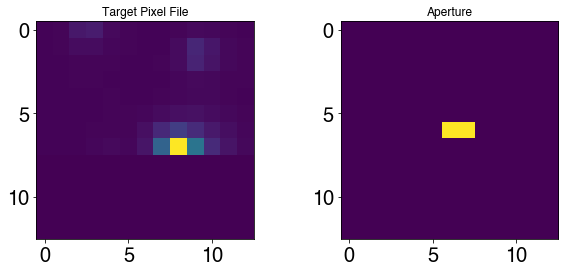

In [70]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,4))
ax1.imshow(data35.tpf[0])
ax1.set_title('Target Pixel File')
ax2.imshow(data35.aperture)
ax2.set_title('Aperture');

In [71]:
star35 = search_targetpixelfile('TIC 299218911').download(quality_bitmask='default');

In [35]:
star35.interact()

In [36]:
star35.interact_sky()

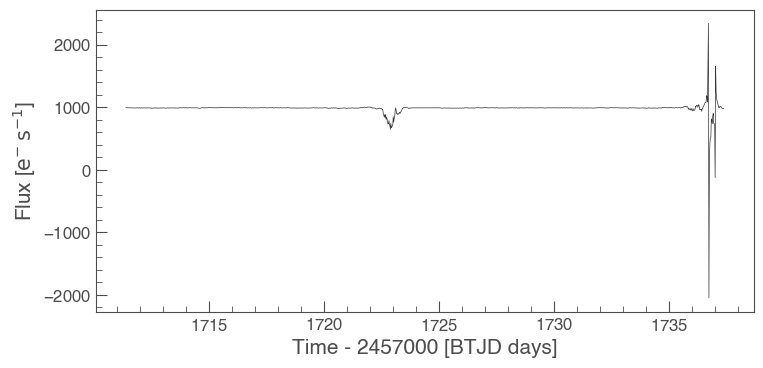

In [72]:
lk = data35.to_lightkurve()
lk.plot()

In [75]:
star53 = eleanor.Source(tic=tics_short_periods[53])
data53 = eleanor.TargetData(star53, do_psf=True, do_pca=True)

No eleanor postcard has been made for your target (yet). Using TessCut instead.




  0%|          | 0/1241 [00:00<?, ?it/s]

  0%|          | 1/1241 [00:14<5:00:37, 14.55s/it]

  0%|          | 3/1241 [00:14<3:30:29, 10.20s/it]

  1%|          | 7/1241 [00:14<2:27:02,  7.15s/it]

  1%|          | 10/1241 [00:14<1:42:53,  5.01s/it]

  1%|          | 13/1241 [00:15<1:12:08,  3.52s/it]

  1%|▏         | 16/1241 [00:15<50:36,  2.48s/it]  

  2%|▏         | 20/1241 [00:15<35:27,  1.74s/it]

  2%|▏         | 23/1241 [00:15<24:58,  1.23s/it]

  2%|▏         | 26/1241 [00:15<17:40,  1.15it/s]

  2%|▏         | 30/1241 [00:15<12:30,  1.61it/s]

  3%|▎         | 34/1241 [00:15<08:55,  2.26it/s]

  3%|▎         | 38/1241 [00:15<06:24,  3.13it/s]

  3%|▎         | 42/1241 [00:15<04:38,  4.30it/s]

  4%|▎         | 46/1241 [00:16<03:24,  5.84it/s]

  4%|▍         | 50/1241 [00:16<02:32,  7.82it/s]

  4%|▍         | 54/1241 [00:16<01:55, 10.30it/s]

  5%|▍         | 58/1241 [00:16<01:30, 13.04it/s]

  5%|▍         | 62/1241 [00:16<01:14, 15.91it/s]

  5%|▌         | 67/1241 [00:

 40%|███▉      | 491/1241 [00:32<00:36, 20.55it/s]

 40%|███▉      | 494/1241 [00:33<00:37, 19.86it/s]

 40%|████      | 497/1241 [00:33<00:34, 21.69it/s]

 40%|████      | 500/1241 [00:33<00:31, 23.42it/s]

 41%|████      | 504/1241 [00:33<00:28, 25.87it/s]

 41%|████      | 507/1241 [00:33<00:28, 25.51it/s]

 41%|████      | 510/1241 [00:33<00:28, 25.53it/s]

 41%|████▏     | 513/1241 [00:33<00:27, 26.71it/s]

 42%|████▏     | 516/1241 [00:34<00:36, 19.94it/s]

 42%|████▏     | 519/1241 [00:34<00:39, 18.50it/s]

 42%|████▏     | 522/1241 [00:34<00:34, 20.76it/s]

 42%|████▏     | 526/1241 [00:34<00:29, 23.95it/s]

 43%|████▎     | 529/1241 [00:34<00:33, 21.44it/s]

 43%|████▎     | 532/1241 [00:34<00:40, 17.47it/s]

 43%|████▎     | 535/1241 [00:34<00:35, 19.68it/s]

 43%|████▎     | 538/1241 [00:35<00:32, 21.93it/s]

 44%|████▎     | 542/1241 [00:35<00:27, 25.13it/s]

 44%|████▍     | 545/1241 [00:35<00:26, 26.32it/s]

 44%|████▍     | 548/1241 [00:35<00:34, 20.25it/s]

 44%|████▍  

 82%|████████▏ | 1017/1241 [00:52<00:08, 25.20it/s]

 82%|████████▏ | 1021/1241 [00:52<00:07, 27.53it/s]

 83%|████████▎ | 1025/1241 [00:52<00:09, 22.00it/s]

 83%|████████▎ | 1028/1241 [00:52<00:10, 21.27it/s]

 83%|████████▎ | 1031/1241 [00:52<00:09, 22.60it/s]

 83%|████████▎ | 1035/1241 [00:52<00:08, 25.34it/s]

 84%|████████▎ | 1038/1241 [00:53<00:09, 22.11it/s]

 84%|████████▍ | 1041/1241 [00:53<00:09, 20.74it/s]

 84%|████████▍ | 1044/1241 [00:53<00:08, 22.71it/s]

 84%|████████▍ | 1048/1241 [00:53<00:07, 25.81it/s]

 85%|████████▍ | 1053/1241 [00:53<00:06, 29.35it/s]

 85%|████████▌ | 1057/1241 [00:53<00:07, 26.07it/s]

 85%|████████▌ | 1060/1241 [00:53<00:08, 21.24it/s]

 86%|████████▌ | 1063/1241 [00:54<00:08, 20.38it/s]

 86%|████████▌ | 1067/1241 [00:54<00:07, 23.79it/s]

 86%|████████▋ | 1071/1241 [00:54<00:06, 26.74it/s]

 87%|████████▋ | 1075/1241 [00:54<00:05, 29.52it/s]

 87%|████████▋ | 1079/1241 [00:54<00:05, 31.15it/s]

 87%|████████▋ | 1083/1241 [00:54<00:04, 31.77

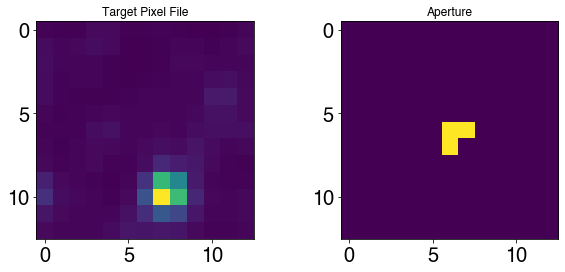

In [27]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,4))
ax1.imshow(data53.tpf[0])
ax1.set_title('Target Pixel File')
ax2.imshow(data53.aperture)
ax2.set_title('Aperture');

In [31]:
star53 = search_targetpixelfile('TIC 184087631').download(quality_bitmask='default');

In [32]:
star53.interact()

In [33]:
star53.interact_sky()

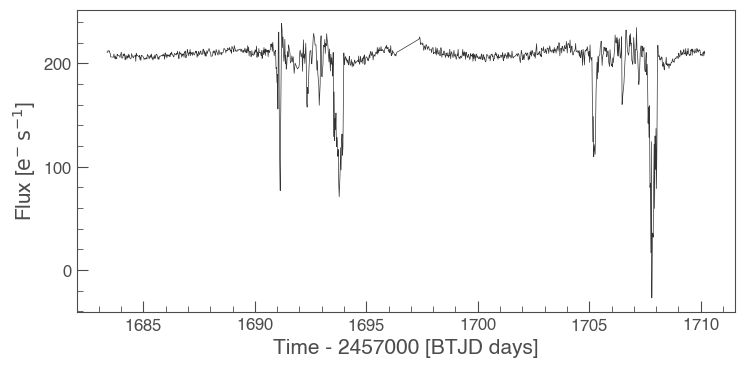

In [76]:
lk = data53.to_lightkurve()
lk.plot()

# stars with wonky lightcurves

In [77]:
star = eleanor.Source(tic=tics_short_periods[1])
data = eleanor.TargetData(star, do_psf=True, do_pca=True)

No eleanor postcard has been made for your target (yet). Using TessCut instead.




  0%|          | 0/1241 [00:00<?, ?it/s]

  0%|          | 1/1241 [00:12<4:27:34, 12.95s/it]

  0%|          | 4/1241 [00:13<3:07:03,  9.07s/it]

  0%|          | 6/1241 [00:13<2:11:02,  6.37s/it]

  1%|          | 10/1241 [00:13<1:31:39,  4.47s/it]

  1%|          | 12/1241 [00:13<1:04:21,  3.14s/it]

  1%|▏         | 16/1241 [00:13<45:06,  2.21s/it]  

  2%|▏         | 21/1241 [00:13<31:34,  1.55s/it]

  2%|▏         | 26/1241 [00:13<22:08,  1.09s/it]

  2%|▏         | 30/1241 [00:13<15:37,  1.29it/s]

  3%|▎         | 34/1241 [00:13<11:03,  1.82it/s]

  3%|▎         | 38/1241 [00:14<07:53,  2.54it/s]

  3%|▎         | 42/1241 [00:14<05:39,  3.53it/s]

  4%|▍         | 47/1241 [00:14<04:04,  4.88it/s]

  4%|▍         | 52/1241 [00:14<02:58,  6.66it/s]

  5%|▍         | 57/1241 [00:14<02:12,  8.94it/s]

  5%|▍         | 62/1241 [00:14<01:41, 11.65it/s]

  5%|▌         | 67/1241 [00:14<01:18, 14.95it/s]

  6%|▌         | 72/1241 [00:14<01:04, 18.03it/s]

  6%|▌         | 77/1241 [00:

 55%|█████▌    | 685/1241 [00:29<00:10, 51.33it/s]

 56%|█████▌    | 691/1241 [00:29<00:10, 50.13it/s]

 56%|█████▌    | 697/1241 [00:29<00:10, 50.54it/s]

 57%|█████▋    | 703/1241 [00:29<00:10, 52.16it/s]

 57%|█████▋    | 709/1241 [00:29<00:10, 50.97it/s]

 58%|█████▊    | 715/1241 [00:29<00:10, 51.60it/s]

 58%|█████▊    | 721/1241 [00:29<00:09, 53.14it/s]

 59%|█████▊    | 727/1241 [00:30<00:09, 53.52it/s]

 59%|█████▉    | 733/1241 [00:30<00:09, 53.23it/s]

 60%|█████▉    | 739/1241 [00:30<00:09, 53.71it/s]

 60%|██████    | 745/1241 [00:30<00:09, 54.86it/s]

 61%|██████    | 751/1241 [00:30<00:09, 52.92it/s]

 61%|██████    | 757/1241 [00:30<00:09, 53.54it/s]

 61%|██████▏   | 763/1241 [00:30<00:09, 51.57it/s]

 62%|██████▏   | 769/1241 [00:30<00:09, 51.39it/s]

 62%|██████▏   | 775/1241 [00:31<00:08, 52.67it/s]

 63%|██████▎   | 781/1241 [00:31<00:08, 54.04it/s]

 63%|██████▎   | 787/1241 [00:31<00:08, 54.97it/s]

 64%|██████▍   | 793/1241 [00:31<00:08, 54.73it/s]

 64%|██████▍

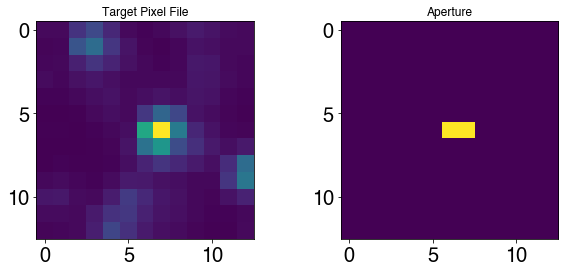

In [32]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,4))
ax1.imshow(data.tpf[0])
ax1.set_title('Target Pixel File')
ax2.imshow(data.aperture)
ax2.set_title('Aperture');

In [29]:
star = search_targetpixelfile('TIC 121789795').download(quality_bitmask='default');

In [30]:
star.interact()

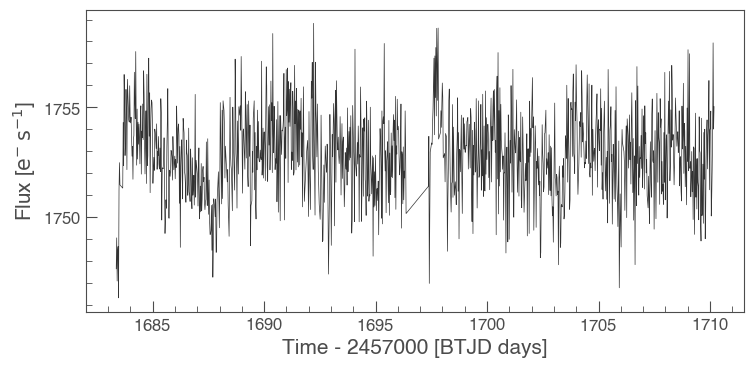

In [78]:
lk = data.to_lightkurve()
lk.plot()

In [ ]:
star_2 = eleanor.Source(name = '121789795')

In [79]:
star2 = eleanor.Source(tic=tics_short_periods[2])
data2 = eleanor.TargetData(star2, do_psf=True, do_pca=True)

No eleanor postcard has been made for your target (yet). Using TessCut instead.




  0%|          | 0/1241 [00:00<?, ?it/s]

  0%|          | 1/1241 [00:16<5:37:29, 16.33s/it]

  0%|          | 4/1241 [00:16<3:55:53, 11.44s/it]

  1%|          | 8/1241 [00:16<2:44:45,  8.02s/it]

  1%|          | 12/1241 [00:16<1:55:08,  5.62s/it]

  1%|▏         | 16/1241 [00:16<1:20:31,  3.94s/it]

  2%|▏         | 19/1241 [00:16<56:34,  2.78s/it]  

  2%|▏         | 22/1241 [00:17<39:48,  1.96s/it]

  2%|▏         | 25/1241 [00:17<28:00,  1.38s/it]

  2%|▏         | 28/1241 [00:17<19:47,  1.02it/s]

  3%|▎         | 32/1241 [00:17<13:58,  1.44it/s]

  3%|▎         | 36/1241 [00:17<09:59,  2.01it/s]

  3%|▎         | 39/1241 [00:17<07:25,  2.70it/s]

  3%|▎         | 42/1241 [00:17<05:30,  3.63it/s]

  4%|▎         | 45/1241 [00:18<04:03,  4.92it/s]

  4%|▍         | 48/1241 [00:18<03:14,  6.12it/s]

  4%|▍         | 51/1241 [00:18<02:30,  7.89it/s]

  4%|▍         | 54/1241 [00:18<01:58, 10.02it/s]

  5%|▍         | 57/1241 [00:18<01:38, 12.07it/s]

  5%|▍         | 60/1241 [00:

 40%|████      | 497/1241 [00:34<00:26, 27.85it/s]

 40%|████      | 500/1241 [00:35<00:26, 27.85it/s]

 41%|████      | 503/1241 [00:35<00:26, 27.56it/s]

 41%|████      | 506/1241 [00:35<00:26, 28.24it/s]

 41%|████      | 510/1241 [00:35<00:24, 29.75it/s]

 41%|████▏     | 514/1241 [00:35<00:23, 31.05it/s]

 42%|████▏     | 519/1241 [00:35<00:20, 34.64it/s]

 42%|████▏     | 524/1241 [00:35<00:19, 37.71it/s]

 43%|████▎     | 528/1241 [00:35<00:19, 37.50it/s]

 43%|████▎     | 532/1241 [00:35<00:19, 37.16it/s]

 43%|████▎     | 537/1241 [00:36<00:17, 39.32it/s]

 44%|████▎     | 542/1241 [00:36<00:17, 40.61it/s]

 44%|████▍     | 547/1241 [00:36<00:16, 42.65it/s]

 44%|████▍     | 552/1241 [00:36<00:16, 42.40it/s]

 45%|████▍     | 557/1241 [00:36<00:16, 42.70it/s]

 45%|████▌     | 562/1241 [00:36<00:15, 43.44it/s]

 46%|████▌     | 567/1241 [00:36<00:15, 43.18it/s]

 46%|████▌     | 572/1241 [00:36<00:15, 42.16it/s]

 46%|████▋     | 577/1241 [00:36<00:15, 41.80it/s]

 47%|████▋  

 89%|████████▊ | 1100/1241 [00:51<00:05, 23.85it/s]

 89%|████████▉ | 1103/1241 [00:51<00:05, 24.07it/s]

 89%|████████▉ | 1106/1241 [00:52<00:05, 24.93it/s]

 89%|████████▉ | 1109/1241 [00:52<00:05, 25.85it/s]

 90%|████████▉ | 1112/1241 [00:52<00:04, 26.88it/s]

 90%|████████▉ | 1115/1241 [00:52<00:04, 27.43it/s]

 90%|█████████ | 1118/1241 [00:52<00:04, 28.10it/s]

 90%|█████████ | 1121/1241 [00:52<00:04, 28.10it/s]

 91%|█████████ | 1124/1241 [00:52<00:04, 27.40it/s]

 91%|█████████ | 1127/1241 [00:52<00:04, 26.70it/s]

 91%|█████████ | 1130/1241 [00:52<00:04, 26.43it/s]

 91%|█████████▏| 1133/1241 [00:53<00:04, 26.80it/s]

 92%|█████████▏| 1136/1241 [00:53<00:03, 26.77it/s]

 92%|█████████▏| 1140/1241 [00:53<00:03, 28.36it/s]

 92%|█████████▏| 1143/1241 [00:53<00:03, 28.36it/s]

 92%|█████████▏| 1146/1241 [00:53<00:03, 27.79it/s]

 93%|█████████▎| 1150/1241 [00:53<00:03, 29.77it/s]

 93%|█████████▎| 1154/1241 [00:53<00:02, 32.04it/s]

 93%|█████████▎| 1158/1241 [00:53<00:02, 31.52

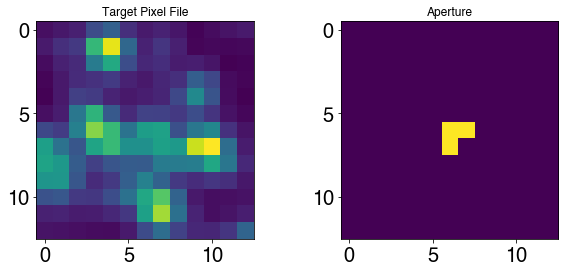

In [42]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,4))
ax1.imshow(data2.tpf[0])
ax1.set_title('Target Pixel File')
ax2.imshow(data2.aperture)
ax2.set_title('Aperture');

In [45]:
star2 = search_targetpixelfile('TIC 171098535').download(quality_bitmask='default');

In [46]:
star2.interact()

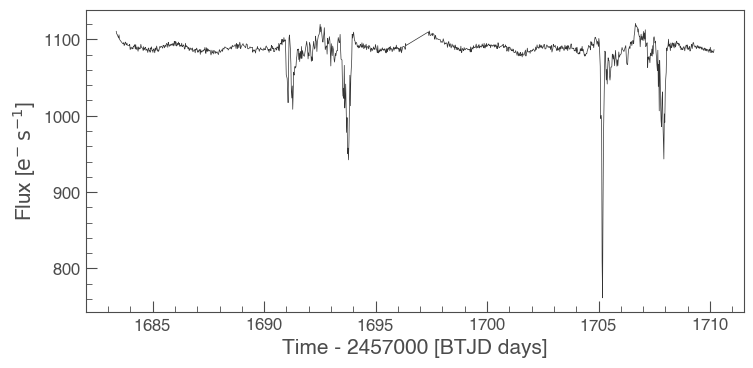

In [80]:
lk = data2.to_lightkurve()
lk.plot()

In [49]:
star3 = eleanor.Source(tic=tics_short_periods[3])
data3 = eleanor.TargetData(star3, do_psf=True, do_pca=True)

No eleanor postcard has been made for your target (yet). Using TessCut instead.




  0%|          | 0/1241 [00:00<?, ?it/s]

  0%|          | 1/1241 [00:12<4:26:40, 12.90s/it]

  0%|          | 4/1241 [00:13<3:06:25,  9.04s/it]

  1%|          | 8/1241 [00:13<2:10:15,  6.34s/it]

  1%|          | 12/1241 [00:13<1:31:03,  4.45s/it]

  1%|          | 15/1241 [00:13<1:03:48,  3.12s/it]

  1%|▏         | 18/1241 [00:13<44:47,  2.20s/it]  

  2%|▏         | 21/1241 [00:13<31:41,  1.56s/it]

  2%|▏         | 24/1241 [00:13<22:20,  1.10s/it]

  2%|▏         | 27/1241 [00:13<15:48,  1.28it/s]

  3%|▎         | 32/1241 [00:13<11:09,  1.81it/s]

  3%|▎         | 36/1241 [00:14<08:02,  2.50it/s]

  3%|▎         | 39/1241 [00:14<05:53,  3.40it/s]

  3%|▎         | 42/1241 [00:14<04:20,  4.61it/s]

  4%|▎         | 45/1241 [00:14<03:15,  6.12it/s]

  4%|▍         | 49/1241 [00:14<02:26,  8.12it/s]

  4%|▍         | 55/1241 [00:14<01:48, 10.89it/s]

  5%|▍         | 60/1241 [00:14<01:23, 14.08it/s]

  5%|▌         | 66/1241 [00:14<01:04, 18.12it/s]

  6%|▌         | 71/1241 [00:

 46%|████▌     | 565/1241 [00:31<00:24, 27.12it/s]

 46%|████▌     | 569/1241 [00:31<00:23, 28.78it/s]

 46%|████▋     | 574/1241 [00:31<00:20, 32.28it/s]

 47%|████▋     | 579/1241 [00:31<00:18, 35.64it/s]

 47%|████▋     | 583/1241 [00:31<00:17, 36.77it/s]

 47%|████▋     | 588/1241 [00:31<00:16, 38.92it/s]

 48%|████▊     | 594/1241 [00:31<00:15, 41.99it/s]

 48%|████▊     | 599/1241 [00:31<00:16, 39.44it/s]

 49%|████▊     | 604/1241 [00:32<00:19, 33.12it/s]

 49%|████▉     | 608/1241 [00:32<00:21, 29.16it/s]

 49%|████▉     | 612/1241 [00:32<00:20, 30.70it/s]

 50%|████▉     | 617/1241 [00:32<00:18, 33.81it/s]

 50%|█████     | 623/1241 [00:32<00:15, 38.64it/s]

 51%|█████     | 628/1241 [00:32<00:14, 41.40it/s]

 51%|█████     | 633/1241 [00:32<00:14, 40.66it/s]

 51%|█████▏    | 638/1241 [00:33<00:15, 39.52it/s]

 52%|█████▏    | 643/1241 [00:33<00:16, 36.51it/s]

 52%|█████▏    | 647/1241 [00:33<00:19, 30.83it/s]

 53%|█████▎    | 652/1241 [00:33<00:17, 33.82it/s]

 53%|█████▎ 

 90%|████████▉ | 1114/1241 [00:50<00:06, 19.16it/s]

 90%|████████▉ | 1116/1241 [00:50<00:06, 19.03it/s]

 90%|█████████ | 1118/1241 [00:50<00:06, 18.46it/s]

 90%|█████████ | 1120/1241 [00:50<00:06, 17.77it/s]

 90%|█████████ | 1122/1241 [00:50<00:07, 16.56it/s]

 91%|█████████ | 1124/1241 [00:50<00:06, 16.79it/s]

 91%|█████████ | 1127/1241 [00:51<00:06, 16.34it/s]

 91%|█████████ | 1130/1241 [00:51<00:06, 17.62it/s]

 91%|█████████ | 1132/1241 [00:51<00:06, 15.77it/s]

 91%|█████████▏| 1134/1241 [00:51<00:06, 15.38it/s]

 92%|█████████▏| 1136/1241 [00:51<00:07, 14.14it/s]

 92%|█████████▏| 1139/1241 [00:51<00:06, 15.73it/s]

 92%|█████████▏| 1142/1241 [00:52<00:05, 17.10it/s]

 92%|█████████▏| 1145/1241 [00:52<00:05, 18.54it/s]

 92%|█████████▏| 1147/1241 [00:52<00:05, 18.47it/s]

 93%|█████████▎| 1149/1241 [00:52<00:04, 18.69it/s]

 93%|█████████▎| 1151/1241 [00:52<00:04, 18.83it/s]

 93%|█████████▎| 1154/1241 [00:52<00:04, 19.61it/s]

 93%|█████████▎| 1156/1241 [00:52<00:04, 18.14

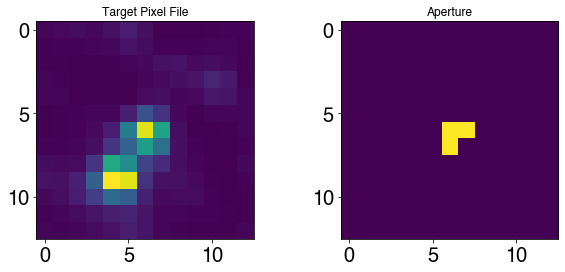

In [50]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,4))
ax1.imshow(data3.tpf[0])
ax1.set_title('Target Pixel File')
ax2.imshow(data3.aperture)
ax2.set_title('Aperture');

In [51]:
star3 = search_targetpixelfile('TIC 121457565').download(quality_bitmask='default');

In [52]:
star3.interact()

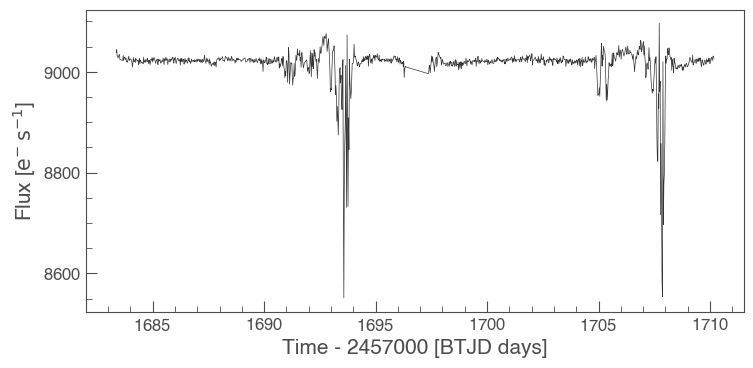

In [64]:
lk = data3.to_lightkurve()
lk.plot()

No eleanor postcard has been made for your target (yet). Using TessCut instead.




  0%|          | 0/1241 [00:00<?, ?it/s]

  0%|          | 1/1241 [00:11<4:00:32, 11.64s/it]

  0%|          | 5/1241 [00:11<2:48:00,  8.16s/it]

  1%|          | 10/1241 [00:11<1:57:15,  5.72s/it]

  1%|          | 14/1241 [00:11<1:21:58,  4.01s/it]

  1%|▏         | 18/1241 [00:12<57:22,  2.81s/it]  

  2%|▏         | 22/1241 [00:12<40:12,  1.98s/it]

  2%|▏         | 27/1241 [00:12<28:10,  1.39s/it]

  2%|▏         | 31/1241 [00:12<19:50,  1.02it/s]

  3%|▎         | 35/1241 [00:12<14:00,  1.43it/s]

  3%|▎         | 39/1241 [00:12<09:56,  2.02it/s]

  3%|▎         | 43/1241 [00:12<07:06,  2.81it/s]

  4%|▍         | 47/1241 [00:12<05:08,  3.87it/s]

  4%|▍         | 51/1241 [00:13<03:45,  5.28it/s]

  4%|▍         | 55/1241 [00:13<02:47,  7.08it/s]

  5%|▍         | 59/1241 [00:13<02:07,  9.24it/s]

  5%|▌         | 63/1241 [00:13<01:38, 11.96it/s]

  5%|▌         | 68/1241 [00:13<01:17, 15.17it/s]

  6%|▌         | 72/1241 [00:13<01:04, 18.11it/s]

  6%|▌         | 77/1241 [00:1

 51%|█████     | 636/1241 [00:28<00:28, 21.35it/s]

 52%|█████▏    | 641/1241 [00:28<00:23, 25.78it/s]

 52%|█████▏    | 646/1241 [00:28<00:19, 29.93it/s]

 52%|█████▏    | 650/1241 [00:28<00:18, 31.63it/s]

 53%|█████▎    | 654/1241 [00:28<00:23, 25.31it/s]

 53%|█████▎    | 658/1241 [00:29<00:22, 26.20it/s]

 53%|█████▎    | 662/1241 [00:29<00:20, 27.62it/s]

 54%|█████▎    | 666/1241 [00:29<00:21, 26.80it/s]

 54%|█████▍    | 669/1241 [00:29<00:20, 27.28it/s]

 54%|█████▍    | 672/1241 [00:29<00:22, 25.42it/s]

 54%|█████▍    | 675/1241 [00:29<00:21, 26.37it/s]

 55%|█████▍    | 680/1241 [00:29<00:18, 30.52it/s]

 55%|█████▌    | 685/1241 [00:29<00:16, 34.45it/s]

 56%|█████▌    | 691/1241 [00:30<00:14, 38.69it/s]

 56%|█████▌    | 697/1241 [00:30<00:12, 42.46it/s]

 57%|█████▋    | 702/1241 [00:30<00:12, 43.94it/s]

 57%|█████▋    | 707/1241 [00:30<00:12, 41.67it/s]

 57%|█████▋    | 712/1241 [00:30<00:12, 42.77it/s]

 58%|█████▊    | 718/1241 [00:30<00:11, 45.83it/s]

 58%|█████▊ 

 97%|█████████▋| 1207/1241 [00:46<00:00, 40.25it/s]

 98%|█████████▊| 1212/1241 [00:46<00:00, 42.34it/s]

 98%|█████████▊| 1217/1241 [00:47<00:00, 41.18it/s]

 98%|█████████▊| 1222/1241 [00:47<00:00, 39.57it/s]

 99%|█████████▉| 1227/1241 [00:47<00:00, 34.56it/s]

 99%|█████████▉| 1231/1241 [00:47<00:00, 33.66it/s]

100%|█████████▉| 1235/1241 [00:47<00:00, 30.56it/s]

100%|██████████| 1241/1241 [00:47<00:00, 25.97it/s]


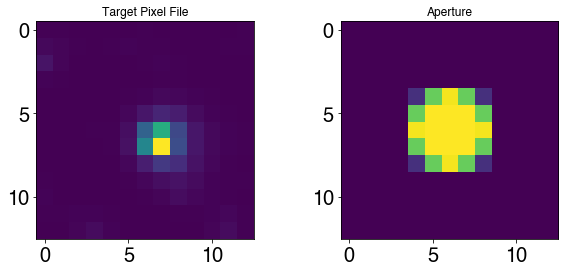

In [55]:
star40 = eleanor.Source(tic=tics_short_periods[40])
data40 = eleanor.TargetData(star40, do_psf=True, do_pca=True)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,4))
ax1.imshow(data40.tpf[0])
ax1.set_title('Target Pixel File')
ax2.imshow(data40.aperture)
ax2.set_title('Aperture');

In [56]:
star40 = search_targetpixelfile('TIC 164652676').download(quality_bitmask='default');

In [57]:
star40.interact()

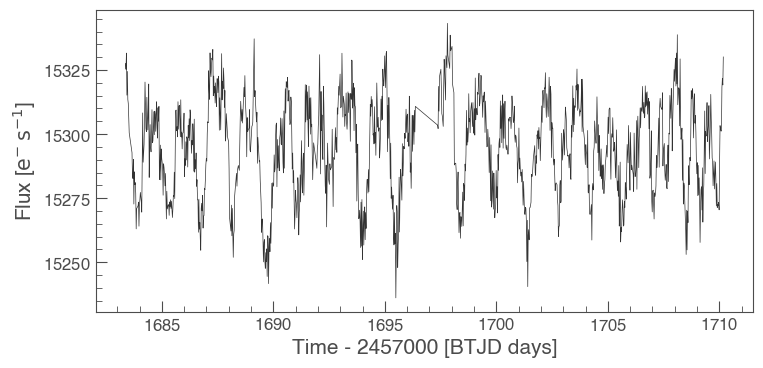

In [63]:
lk = data40.to_lightkurve()
lk.plot()

In [53]:
tics_short_periods[40]

164652676